# 第6週：分析PTT速食版麥當勞相關文章之詞彙關係

本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。以速食版麥當勞相關文章做為分析資料。


## 大綱
1. 套件說明 
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. 找出重要詞彙 - 以TFIDF為例
    - 3.1 計算TF-IDF示範（公式）
    - 3.2 應用於資料集（套件） 
    - 3.3 檢視結果
4.  透過結巴斷詞與N-gram幫助建立斷詞字典
    - 4.1 Bigram
    - 4.2 Trigram
    - 4.3 更新斷詞字典
    - 4.4 Bigram視覺化
5.  Pairwise correlation
    - 5.1 找出相關性高的詞彙
    - 5.2 畫出關係圖
6. 計算文章相似度
7. 補充：建立Ngram預測模型


## 1. 套件說明

下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [898]:
# ％pip install -U networkx

In [899]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [900]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [901]:
# cloab 字體設定

# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)文章
+ 關鍵字:「吃到飽」
+ 時間: 2020-01-01 ~ 2022-12-31
+ 資料筆數：共 1630 篇文章

In [902]:
#匯入資料
df = pd.read_csv('./raw_data/ptt_麥當勞_20250323_090242.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,msun,fastfood,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,"[{'cmtStatus': '→', 'cmtPoster': 'Tsuyoi', 'cm...",1.160.206.25,2025-03-23 08:21:11,ptt
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,jasonsinica,fastfood,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,"[{'cmtStatus': '推', 'cmtPoster': 'baiyutw', 'c...",111.246.194.68,2025-03-23 08:21:14,ptt
2,3,https://www.ptt.cc/bbs/fastfood/M.1742012365.A...,[商品] 麥當勞 蛇年開春 F40雙人早餐,2025-03-15 12:19:23,jasonsinica,fastfood,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...,"[{'cmtStatus': '→', 'cmtPoster': 'syensyens', ...",111.246.194.68,2025-03-23 08:21:15,ptt


### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [903]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...
2,3,https://www.ptt.cc/bbs/fastfood/M.1742012365.A...,[商品] 麥當勞 蛇年開春 F40雙人早餐,2025-03-15 12:19:23,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...,廠商分店別麥當勞苗栗店商品名稱蛇年開春雙人早餐內容物價格評分心得今天起床太晚加上外面下著大雷...


### 2.3 文章斷詞與整理

In [904]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/mc_stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [905]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [906]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /Users/huangliangtzu/Documents/碩一下/社群媒體分析/SMA_2025S/week6/dict/dict.txt.big ...
Loading model from cache /var/folders/by/zdnxl2qs6yn22x_24k_9h12c0000gn/T/jieba.u7c1f4e2c6f2f4ee0bfadabf7f598a2b7.cache
Loading model cost 0.484 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...,玩具
2,3,https://www.ptt.cc/bbs/fastfood/M.1742012365.A...,[商品] 麥當勞 蛇年開春 F40雙人早餐,2025-03-15 12:19:23,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...,廠商分店別麥當勞苗栗店商品名稱蛇年開春雙人早餐內容物價格評分心得今天起床太晚加上外面下著大雷...,介紹


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 3.1 計算TF-IDF示範（公式）

#### 建立示範文件

In [907]:
# 一些短句子示範
doc1 = """中山大學位於高雄柴山地區，附近野生獼猴猖獗，常搶學生食物，甚至抓傷學生，學校推出「與獼猴共存」政策，學生食物若被獼猴搶走，每次可向學校申請上限一百元補償金。
中山大學校園內近日張貼公告，宣導學生食物不外露，勿手拿會吸引獼猴搶奪的食物、提袋、塑膠袋或紙袋等，「如遇到獼猴掠食，先確保自身安全，放棄食物，避免在爭奪過程中受傷」。
校方於二至七月試辦補償措施，只要學生在柴山校區的商店購買食物被獼猴搶食，可到校內店家再次購買餐食，每人每餐補償上限為一百元，不過截至昨天為止，尚未有同學提出申請。"""

doc2 = """國立中山大學為住宿學生提供貼心服務，引進現煮拉麵熱食販賣機，並開放24小時使用「自煮空間」，滿足所有住宿學生的味蕾。
宿舍區同步升級多項軟硬體設施，包含逐步整修換新、定期辦理主題講座、職涯發展分享會、節慶交流活動、增設更多公共空間，並推動「衣服再利用」永續計畫，期能兼顧各種需求，提升住宿品質。
中山大學為方便住宿學生就近覓食，特地引進現煮拉麵熱食販賣機，於今年1月初進駐校園翠亨C棟、雨樹L棟及武嶺武二村聽濤堂前三個宿舍區點，鄰近自習室公共空間，提供大家更多選擇。"""

doc3 = """為了促進第二、第三外語與跨文化學習交流，國立中山大學外文系首辦「在中山說第二外語」語言交換活動，打造練習外語聽說環境，使學生在中山便有機會認識世界、擴展視野，
在全球化下能海納百川，欣賞多國多語言的多元文化。「在中山說第二外語」語言交換活動獲文學院與國際事務處支持推廣，學生參與踴躍，2場次參加人數達70人次，
其中多達半數為非外文系學生，參與外籍生亦來自歐、亞、美洲等不同國家，活動中以德文、法文、西班牙文、日文及韓文使用者為大宗。"""

sample_df = pd.DataFrame({'doc':[1,2,3], 'text': [doc1, doc2, doc3]})

sample_df

,doc,text
0,1,中山大學位於高雄柴山地區，附近野生獼猴猖獗，常搶學生食物，甚至抓傷學生，學校推出「與獼猴共存...
1,2,國立中山大學為住宿學生提供貼心服務，引進現煮拉麵熱食販賣機，並開放24小時使用「自煮空間」，...
2,3,為了促進第二、第三外語與跨文化學習交流，國立中山大學外文系首辦「在中山說第二外語」語言交換活...


資料清理

In [908]:
sample_df['text'] = sample_df['text'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
sample_df = sample_df.assign(word = sample_df['text'].apply(getToken)).explode('word')

sample_df.head()

,doc,text,word
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,中山大學
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,山地區
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,野生
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,獼猴
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,猖獗


#### 計算各文章的總詞彙數

In [909]:
total_words = sample_df.groupby(['doc'], as_index=False).size().rename(columns={'size': 'total'})
total_words.head()

,doc,total
0,1,66
1,2,65
2,3,58


#### 計算各文章的各個詞彙數

In [910]:
word_count = sample_df.groupby(['doc', 'word'], as_index = False).size()

word_count.rename(columns={'size': 'count'}, inplace=True)
word_count.sort_values('count', ascending=False).head()

,doc,word,count
41,1,獼猴,6
16,1,學生,5
122,3,外語,4
56,2,住宿,4
107,3,中山,3


合併需要的資料欄位
- 合併 **每個詞彙在每篇文章中出現的次數** 與 **每篇文章的詞數**

In [911]:
sample_merged = word_count.merge(total_words, on = 'doc', how = 'left')
sample_merged.head(3)

,doc,word,count,total
0,1,一百元,2,66
1,1,七月,1,66
2,1,上限,2,66


#### 計算 TF值

In [912]:
# 計算tf = 詞彙在該文件中出現次數 / 該文件中詞彙總數 
sample_tf_idf = sample_merged.assign(tf = sample_merged["count"] / sample_merged["total"])
sample_tf_idf.head()

,doc,word,count,total,tf
0,1,一百元,2,66,0.030303
1,1,七月,1,66,0.015152
2,1,上限,2,66,0.030303
3,1,中山大學,2,66,0.030303
4,1,二至,1,66,0.015152


#### 計算 IDF值

In [913]:
# 計算每個詞彙出現在幾篇文章中
idf_df = sample_merged.groupby(['word'], as_index = False).size()

# 合併到之前的df中
sample_tf_idf = sample_tf_idf.merge(idf_df, on = 'word', how = 'left')

sample_tf_idf.head()

,doc,word,count,total,tf,size
0,1,一百元,2,66,0.030303,1
1,1,七月,1,66,0.015152,1
2,1,上限,2,66,0.030303,1
3,1,中山大學,2,66,0.030303,3
4,1,二至,1,66,0.015152,1


In [914]:
# 計算idf = log( 總文件數量 / 包含該詞彙的文件數量 ) 
sample_tf_idf = sample_tf_idf.assign(idf = sample_tf_idf["size"].apply(lambda size: math.log( len(total_words) / size, 10 ))).drop(["size"], axis=1)

sample_tf_idf.head()

,doc,word,count,total,tf,idf
0,1,一百元,2,66,0.030303,0.477121
1,1,七月,1,66,0.015152,0.477121
2,1,上限,2,66,0.030303,0.477121
3,1,中山大學,2,66,0.030303,0.000000
4,1,二至,1,66,0.015152,0.477121


#### 計算 TFIDF值

In [915]:
# 計算tf*idf
sample_tf_idf = sample_tf_idf.assign(tf_idf = sample_tf_idf["tf"] * sample_tf_idf["idf"])

sample_tf_idf.sort_values('tf_idf', ascending = False).head(10)

,doc,word,count,total,tf,idf,tf_idf
41,1,獼猴,6,66,0.090909,0.477121,0.043375
122,3,外語,4,58,0.068966,0.477121,0.032905
56,2,住宿,4,65,0.061538,0.477121,0.029361
145,3,語言,3,58,0.051724,0.477121,0.024679
107,3,中山,3,58,0.051724,0.477121,0.024679
110,3,交換,2,58,0.034483,0.477121,0.016452
117,3,參與,2,58,0.034483,0.477121,0.016452
120,3,外文系,2,58,0.034483,0.477121,0.016452
57,2,公共,2,65,0.030769,0.477121,0.014681
69,2,宿舍區,2,65,0.030769,0.477121,0.014681


In [916]:
# 選出每個文件，tf-idf值最大的前三個詞
group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))
group

/var/folders/by/zdnxl2qs6yn22x_24k_9h12c0000gn/T/ipykernel_72496/1751358733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))


doc word  count  total        tf       idf    tf_idf
doc                                                          
1   41     1   獼猴      6     66  0.090909  0.477121  0.043375
    0      1  一百元      2     66  0.030303  0.477121  0.014458
    2      1   上限      2     66  0.030303  0.477121  0.014458
2   56     2   住宿      4     65  0.061538  0.477121  0.029361
    57     2   公共      2     65  0.030769  0.477121  0.014681
    69     2  宿舍區      2     65  0.030769  0.477121  0.014681
3   122    3   外語      4     58  0.068966  0.477121  0.032905
    107    3   中山      3     58  0.051724  0.477121  0.024679
    145    3   語言      3     58  0.051724  0.477121  0.024679

### 3.2 應用於資料集（套件）

除了直接用公式計算，也可以使用sklearn中計算詞頻與tf-idf的套件。

DTM 介紹
- Document term matrix (DTM)，是一種用於自然語言處理的數學矩陣，描述了在一組文件中各個詞彙出現的頻率。   
- DTM 中的每一行代表一個文件(Document)，每一列代表一個詞彙(Term)，每一格的值表示該詞彙在該文件中的出現次數。

舉例來說，若有三個文件其內容如下：
- 文件1：「今天天氣很好」
- 文件2：「今天是星期五」
- 文件3：「昨天是星期四而且天氣很好」

而這些文件斷完詞後的結果可能為：
- 文件1：「今天／天氣／很／好」
- 文件2：「今天／是／星期五」
- 文件3：「昨天／是／星期四／而且／天氣／很／好」

將這三個文件以DTM格式表示則如下圖：   

<img src="./img/DTM_exsample.png" style="float:left;" width="70%">   

In [917]:
food_df = MetaData.copy()
food_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...
2,3,https://www.ptt.cc/bbs/fastfood/M.1742012365.A...,[商品] 麥當勞 蛇年開春 F40雙人早餐,2025-03-15 12:19:23,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...,廠商分店別麥當勞苗栗店商品名稱蛇年開春雙人早餐內容物價格評分心得今天起床太晚加上外面下著大雷...


In [918]:
# 保留需要的欄位
food_df = food_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
food_df['word'] = food_df.sentence.apply(getToken).map(' '.join)

food_df.head()

,system_id,sentence,word
0,1,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童 玩具 介紹 資料
1,2,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...,廠商 苗栗 商品名稱 草莓 優格 雙餡 評分 很快 售完 錯過 買來 嚐鮮 結論 理想 草莓...
2,3,廠商分店別麥當勞苗栗店商品名稱蛇年開春雙人早餐內容物價格評分心得今天起床太晚加上外面下著大雷...,廠商 苗栗 商品名稱 開春 雙人 早餐 評分 起床 太晚 外面 下著 雷雨 原本 打算 熊貓...
3,4,麥當勞甜心卡今開賣常見問題注意事項曝草莓冰炫風上市記者蕭涵云綜合報導麥當勞甜心卡今日開搶全新...,甜心 卡今 開賣 常見問題 注意事項 草莓 冰炫風 上市 蕭涵 綜合 甜心 今日 開搶 實體...
4,5,各位大大晚安想請問麥當勞的監視器影像會保留多久呢不知道在這個版問對不對主要是當天很確定我在麥...,晚安 監視器 影像 保留 多久 當天 兩點 一線 有將 遺失 袋子 天才 袋子 不見 家裡 ...


In [919]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(food_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一上午,一下子,一不做,一中,一事,一二,一亮,一人,一代,...,龍蝦,龍蝦肉,龍邦,龍門,龍門路,龍頭,龐大,龜山,龜山鄉,龜速版
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [920]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一上午,一下子,一不做,一中,一事,一二,一亮,一人,一代,...,龍蝦,龍蝦肉,龍邦,龍門,龍門路,龍頭,龐大,龜山,龜山鄉,龜速版
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [921]:
food_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
food_tfidf.columns = ["word", "avg"]

food_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
10064,漢堡,0.025179
12811,臺灣,0.024946
16861,麥克,0.024323
16061,雞塊,0.022271
5051,套餐,0.021702
13133,薯條,0.019033
1769,優惠,0.018663
14264,起司,0.016194
16433,飲料,0.015054
10543,牛肉,0.012811


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [922]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一上午,一下子,一不做,一中,一事,一二,一亮,一人,...,龍蝦,龍蝦肉,龍邦,龍門,龍門路,龍頭,龐大,龜山,龜山鄉,龜速版
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [923]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
17080995,996,龜速版,0.0
17080996,997,龜速版,0.0
17080997,998,龜速版,0.0
17080998,999,龜速版,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [924]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

/var/folders/by/zdnxl2qs6yn22x_24k_9h12c0000gn/T/ipykernel_72496/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
0,一一,102
1,一上午,79
1929,套餐,56
2,一下子,55
5642,麥克,52
3608,漢堡,49
674,優惠,46
5402,雞塊,42
4553,薯條,39
4875,起司,39


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

N-gram範例：

In [925]:
token = jieba.lcut("中山資管全國第一")
token

['中山', '資管', '全國', '第一']

In [926]:
# 利用nltk的ngrams()
# Bigram
bigram  = ngrams(token, 2)
list(bigram)

[('中山', '資管'), ('資管', '全國'), ('全國', '第一')]

In [927]:
# Trigram
trigram  = ngrams(token, 3)
list(trigram)

[('中山', '資管', '全國'), ('資管', '全國', '第一')]

### 4.1 Bigram

In [928]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [929]:
food_bigram = MetaData.copy()

food_bigram["word"] = food_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
food_bigram = food_bigram.explode('word')

food_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童 玩具
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,玩具 介紹
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,介紹 資料


#### 統計最常出現的bigram組合

In [930]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram['word'].value_counts().reset_index()

food_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,麥克 雞塊,137
1,微牽絲 起司,98
2,臺灣 臺灣,93
3,金迎 招財,87
4,安格斯 牛肉,81
5,招財 薯來堡,74
6,起司 排雙,73
7,排雙 牛堡,66
8,雙層 牛肉,65
9,超值 全餐,55


### 4.2 Trigram

In [931]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
food_trigram = food_trigram.explode('word')

food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童 玩具 介紹
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,玩具 介紹 資料
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...,廠商 苗栗 商品名稱


#### 統計最常出現的trigram組合

In [932]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram['word'].value_counts().reset_index()

food_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,金迎 招財 薯來堡,71
1,起司 排雙 牛堡,66
2,微牽絲 起司 排雙,55
3,面積 高度 部份,37
4,蕃茄醬 包做 比例,36
5,起司 排脆 豬堡,36
6,日式 豬排 魷魚,34
7,法式 第戎 火腿,33
8,起司 脆薯 雙牛堡,32
9,帕瑪森 主廚 雞腿,30


從上面的 bigram 和 trigram 的結果中，我們發現"餐廳 名稱"、"服務 人員"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

### 4.3 使用自建字典

In [933]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/mc_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [934]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,玩具
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,介紹


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [935]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童 玩具
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,玩具 介紹
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,介紹 資料


In [936]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('臺灣', '臺灣'), 93),
 (('單點', '套餐'), 46),
 (('豬肉', '滿福堡'), 43),
 (('豬排', '魷魚'), 40),
 (('廠商', '商品名稱'), 39)]

除了利用N-gram來幫助建立斷詞字典，N-gram也能幫助我們發現詞與詞之間的連貫關係。

接下來針對重新斷詞後的bigram出現頻率最高的前50對進行視覺化，觀察文章的關鍵詞對

In [937]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [938]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

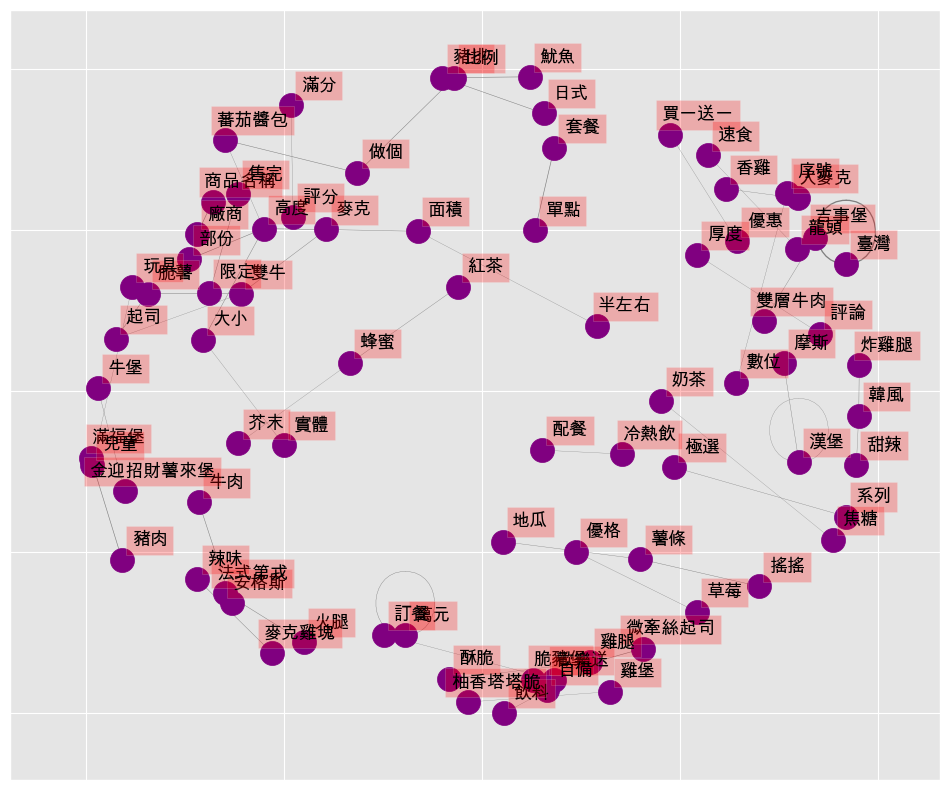

In [939]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

使用[numpy.corrcoef](https://numpy.org/doc/2.2/reference/generated/numpy.corrcoef.html)的方法計算

In [940]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童 玩具 介紹 資料
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...,廠商 苗栗 商品名稱 草莓 優格 雙餡派 評分 很快 售完 錯過 買來 嚐鮮 結論 理想 草...
2,3,https://www.ptt.cc/bbs/fastfood/M.1742012365.A...,[商品] 麥當勞 蛇年開春 F40雙人早餐,2025-03-15 12:19:23,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...,廠商分店別麥當勞苗栗店商品名稱蛇年開春雙人早餐內容物價格評分心得今天起床太晚加上外面下著大雷...,廠商 苗栗 商品名稱 開春 雙人 早餐 評分 起床 太晚 外面 下著 雷雨 原本 打算 熊貓...


In [941]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一包,一名,一家,一張,三重,下次,不想,中壢,中山,中山路,...,麥脆,麥香雞,麥香魚,黑胡椒,點了,點心,點數,點餐機,點點卡,龍蝦
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,0
997,0,0,0,0,1,0,0,0,0,0,...,0,0,2,0,0,0,1,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [942]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一包,一名,一家,一張,三重,下次,不想,中壢,中山,...,麥脆,麥香雞,麥香魚,黑胡椒,點了,點心,點數,點餐機,點點卡,龍蝦
0,一包,1.000000,-0.023181,-0.009043,-0.004386,0.262696,0.014521,0.009228,-0.005917,-0.006949,...,-0.021602,-0.029920,-0.021613,0.009103,0.009072,0.009103,-0.025800,-0.018597,-0.024587,-0.010726
1,一名,-0.023181,1.000000,0.131923,0.012516,-0.013599,-0.011978,-0.024342,-0.006146,-0.004579,...,-0.022437,-0.031076,-0.022448,-0.021748,-0.012931,-0.008422,-0.026797,-0.033762,-0.025537,-0.011140
2,一家,-0.009043,0.131923,1.000000,-0.017050,0.109207,0.034500,0.033291,0.133331,0.126421,...,-0.011828,0.014300,-0.001264,-0.023688,-0.009308,-0.023688,-0.029187,0.026892,-0.027815,-0.012134
3,一張,-0.004386,0.012516,-0.017050,1.000000,-0.016185,-0.005857,-0.014700,-0.007315,-0.008590,...,-0.017676,-0.002516,-0.005968,-0.025884,-0.035224,0.039745,0.006390,0.035783,0.036150,-0.001829
4,三重,0.262696,-0.013599,0.109207,-0.016185,1.000000,0.000425,-0.004821,0.884584,0.870359,...,-0.012672,-0.006771,-0.007487,0.053404,0.014087,0.020560,-0.010781,-0.017168,-0.009220,-0.006292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,點心,0.009103,-0.008422,-0.023688,0.039745,0.020560,-0.006813,-0.021988,-0.005552,-0.006519,...,-0.020267,0.005400,0.049570,-0.019645,-0.026734,1.000000,-0.015194,-0.030497,-0.012298,-0.010063
296,點數,-0.025800,-0.026797,-0.029187,0.006390,-0.010781,0.062091,0.100286,-0.005730,-0.008033,...,0.033909,-0.022754,0.165910,-0.024205,0.040309,-0.015194,1.000000,0.047957,0.428438,-0.012399
297,點餐機,-0.018597,-0.033762,0.026892,0.035783,-0.017168,0.041238,0.162631,-0.008618,-0.010121,...,0.049710,-0.038411,0.007080,-0.026563,-0.031662,-0.030497,0.047957,1.000000,0.037735,-0.015622
298,點點卡,-0.024587,-0.025537,-0.027815,0.036150,-0.009220,0.432873,0.021018,-0.003866,-0.007655,...,-0.005281,-0.015286,0.051096,-0.023068,0.056143,-0.012298,0.428438,0.037735,1.000000,-0.011816


In [943]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
16857,台北市,台中市,0.998521
17156,台中市,台北市,0.998521
17084,高雄市,台中市,0.998087
85256,台中市,高雄市,0.998087
17384,高雄市,台北市,0.997916
85257,台北市,高雄市,0.997916
2384,高雄市,中壢,0.996133
85207,中壢,高雄市,0.996133
36956,台中市,新北市,0.994621
16923,新北市,台中市,0.994621


### 5.1 和 「大麥克」, 「麥香雞」 相關性最高的 10 個詞彙

In [944]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "大麥克")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "麥香雞")].sort_values(by = ['cor'], ascending = False).head(10)

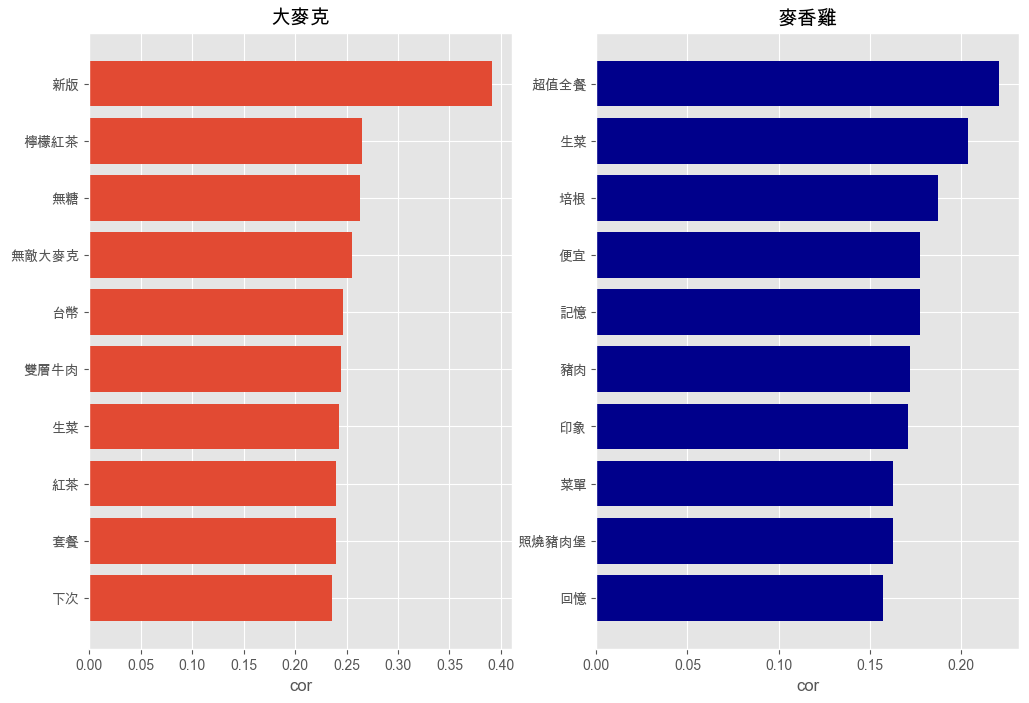

In [945]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('大麥克')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('麥香雞')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [946]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [947]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,炸雞,優惠,0.457952
1,肯德基,優惠,0.369293
2,買一送一,優惠,0.575607
3,速食,優惠,0.577924
4,甜心卡,兌換,0.333188
...,...,...,...
175,兌換,點數,0.556278
176,點點卡,點數,0.428438
177,櫃檯,點餐機,0.576606
178,兌換,點點卡,0.385288


In [948]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

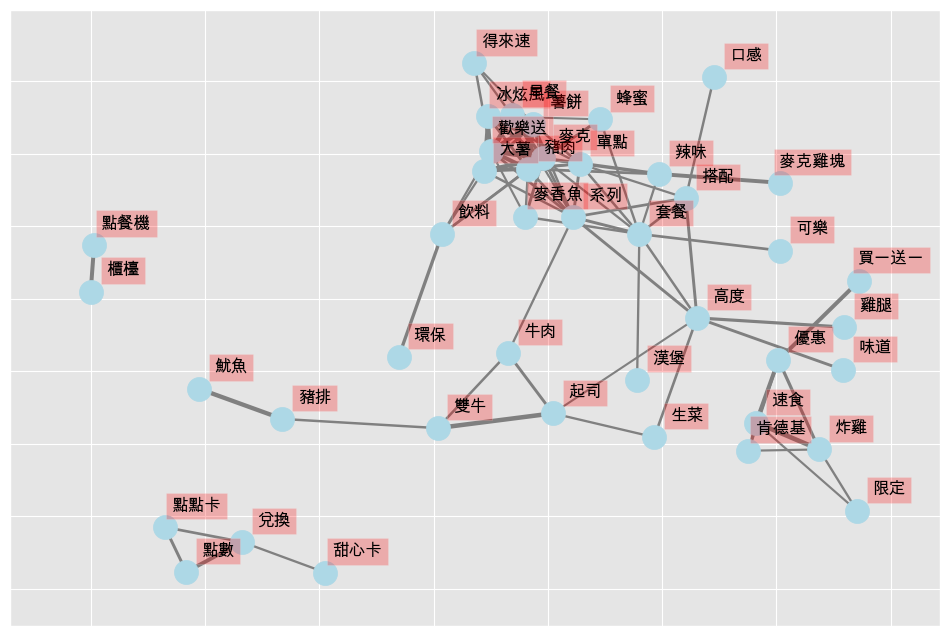

In [949]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [950]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,2025-03-21 19:11:17,日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...,日本麥當勞起兒童餐玩具哆啦夢秒介紹影片第彈金木第彈金木第彈金第彈第彈全種資料來源文章網址,兒童 玩具 介紹 資料
1,2,https://www.ptt.cc/bbs/fastfood/M.1742097993.A...,[商品] 麥當勞 草莓優格雙餡派,2025-03-16 12:06:31,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...,廠商分店別麥當勞苗栗店商品名稱草莓優格雙餡派內容物價格評分心得最近看到麥當勞推出新的派口味想...,廠商 苗栗 商品名稱 草莓 優格 雙餡派 評分 很快 售完 錯過 買來 嚐鮮 結論 理想 草...
2,3,https://www.ptt.cc/bbs/fastfood/M.1742012365.A...,[商品] 麥當勞 蛇年開春 F40雙人早餐,2025-03-15 12:19:23,《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...,廠商分店別麥當勞苗栗店商品名稱蛇年開春雙人早餐內容物價格評分心得今天起床太晚加上外面下著大雷...,廠商 苗栗 商品名稱 開春 雙人 早餐 評分 起床 太晚 外面 下著 雷雨 原本 打算 熊貓...


In [951]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一包,一名,一家,一張,三重,下次,不想,中壢,中山,中山路,...,麥脆,麥香雞,麥香魚,黑胡椒,點了,點心,點數,點餐機,點點卡,龍蝦
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.202502,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.013935,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.011568,0.000000,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.098257,0.0,0.000000,0.000000,0.0,0.0,0.0,0.130932,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
996,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.317288,0.000000,0.697984,0.0
997,0.0,0.000000,0.0,0.000000,0.038289,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.065358,0.0,0.0,0.000000,0.030351,0.000000,0.000000,0.0
998,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.485339,0.000000,0.0


計算文章間的cosine similarity

In [952]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [953]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
995,0.0
996,0.0
997,0.0
998,0.0


In [954]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢,https://www.ptt.cc/bbs/fastfood/M.1742555480.A...
98,0.848869,[情報] 日本麥當勞11/15兒童餐玩具-馬利歐賽車8,https://www.ptt.cc/bbs/fastfood/M.1731042051.A...
546,0.788811,[討論] 冷知識-一些麥當勞兒童餐的由來,https://www.ptt.cc/bbs/fastfood/M.1684859747.A...
72,0.637434,Re: [討論] 麥當勞為什麼對小孩吸引力不減？,https://www.ptt.cc/bbs/fastfood/M.1732443627.A...
549,0.598007,[討論] 中國麥當勞跟中國肯德基的六一玩具對決,https://www.ptt.cc/bbs/fastfood/M.1684610760.A...
950,0.573767,Re: [問題] 請問麥當勞的紅色微笑盒子,https://www.ptt.cc/bbs/fastfood/M.1658074032.A...
424,0.557644,[討論] 日本麥當勞一些小朋友勞作影片(舊影片),https://www.ptt.cc/bbs/fastfood/M.1696694995.A...
73,0.501244,[討論] 麥當勞為什麼對小孩吸引力不減？,https://www.ptt.cc/bbs/fastfood/M.1732409313.A...
247,0.478888,[食記] 越南峴港麥當勞&肯德基(圖少),https://www.ptt.cc/bbs/fastfood/M.1712370503.A...
166,0.444960,[問題] 麥當勞兒童餐89元?,https://www.ptt.cc/bbs/fastfood/M.1722626183.A...


檢視與第14篇文章相似的文章

In [955]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
14,1.000000,Fw: [新聞] 成人平台女模爆麥當勞脫褲裸拍！不雅片,https://www.ptt.cc/bbs/fastfood/M.1740742288.A...
334,0.396252,[新聞] 老婆被麥當勞同事惹怒 美牧師竟衝店內,https://www.ptt.cc/bbs/fastfood/M.1704109114.A...
939,0.369042,[新聞] 麥當勞吃宵夜「米奇跑到腳邊」正妹嚇瘋,https://www.ptt.cc/bbs/fastfood/M.1659081934.A...
524,0.367467,[新聞] 太狂！奧客搗亂 麥當勞員工霸氣潑他滿臉,https://www.ptt.cc/bbs/fastfood/M.1687599999.A...
491,0.361774,[情報] 麥當勞APP 父親節炫父刮刮樂,https://www.ptt.cc/bbs/fastfood/M.1691425206.A...
16,0.327340,Fw: [新聞] 徒步20公里找麥當勞!新北女大雨中迷途 金山警助平安返家,https://www.ptt.cc/bbs/fastfood/M.1740535140.A...
211,0.307208,[新聞] 台灣也有！日本人氣「麥當勞家家酒」限定,https://www.ptt.cc/bbs/fastfood/M.1716882614.A...
175,0.298999,[情報] 香港麥當勞開賣鬆餅堡,https://www.ptt.cc/bbs/fastfood/M.1722071028.A...
448,0.292794,[食記] 香港麥當勞期間限定新品分享,https://www.ptt.cc/bbs/fastfood/M.1695028339.A...
152,0.282995,[新聞] 麥當勞驚見女「打包洗手乳」 影片曝光網,https://www.ptt.cc/bbs/fastfood/M.1724631993.A...


## 7. 補充：建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

---
**以Bi-gram為例：中山＿＿該填甚麼?**  
[ ["中山","資管","全國","第一"],  ["歡迎","來到","中山","大學"],  ["中山","資管","碩士","開放","報名"] ]  
$$ p(w|中山) = \frac {count(中山,w)} {count(中山)} $$
           
$$ p(資管|中山) = \frac {2} {3} $$
$$ p(大學|中山) = \frac {1} {3} $$

In [956]:
test_list = [["中山","資管","全國","第一"],
             ["歡迎","來到","中山","大學"],
             ["中山","資管","碩士","開放","報名"]]

In [957]:
N=2
ngram_prediction = dict()
total_grams = list()
words = list()
Word = namedtuple('Word', ['word', 'prob'])

for doc in test_list:
    # 加上開頭和結尾 tag
    split_words = ['<s>'] + list(doc) + ['</s>']
    # 計算分子
    total_grams = total_grams + list(ngrams(split_words, N))
    print(total_grams)
    # 計算分母
    words = words + list(ngrams(split_words, N-1))
    print(words)
    print('')
        
total_word_counter = Counter(total_grams)
word_counter = Counter(words)

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>'), ('<s>', '中山'), ('中山', '資管'), ('資管', '碩士'), ('碩士', '開放'), ('開放', '報名'), ('報名', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',), ('<s>',), ('中山',), ('資管',), ('碩士',), ('開放',), ('報名',), ('</s>',)]



In [958]:
# 分子
total_word_counter

Counter({('<s>', '中山'): 2,
         ('中山', '資管'): 2,
         ('資管', '全國'): 1,
         ('全國', '第一'): 1,
         ('第一', '</s>'): 1,
         ('<s>', '歡迎'): 1,
         ('歡迎', '來到'): 1,
         ('來到', '中山'): 1,
         ('中山', '大學'): 1,
         ('大學', '</s>'): 1,
         ('資管', '碩士'): 1,
         ('碩士', '開放'): 1,
         ('開放', '報名'): 1,
         ('報名', '</s>'): 1})

In [959]:
# 分母
word_counter

Counter({('<s>',): 3,
         ('中山',): 3,
         ('</s>',): 3,
         ('資管',): 2,
         ('全國',): 1,
         ('第一',): 1,
         ('歡迎',): 1,
         ('來到',): 1,
         ('大學',): 1,
         ('碩士',): 1,
         ('開放',): 1,
         ('報名',): 1})

In [960]:
for key in total_word_counter:
    word = ''.join(key[:N-1])
    if word not in ngram_prediction:
        ngram_prediction.update({word: set()})

    # 算出預測機率，新增至 ngram_prediction
    next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
    w = Word(key[-1], '{:.3g}'.format(next_word_prob))
    ngram_prediction[word].add(w)

In [961]:
ngram_prediction

{'<s>': {Word(word='中山', prob='0.667'), Word(word='歡迎', prob='0.333')},
 '中山': {Word(word='大學', prob='0.333'), Word(word='資管', prob='0.667')},
 '資管': {Word(word='全國', prob='0.5'), Word(word='碩士', prob='0.5')},
 '全國': {Word(word='第一', prob='1')},
 '第一': {Word(word='</s>', prob='1')},
 '歡迎': {Word(word='來到', prob='1')},
 '來到': {Word(word='中山', prob='1')},
 '大學': {Word(word='</s>', prob='1')},
 '碩士': {Word(word='開放', prob='1')},
 '開放': {Word(word='報名', prob='1')},
 '報名': {Word(word='</s>', prob='1')}}

**使用我們的吃到飽資料集**

In [962]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [963]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [964]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [965]:
text = '喜歡'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 喜歡, probability: 0.0414
next word: 漢堡, probability: 0.0345
next word: 風味, probability: 0.0276
next word: 起司, probability: 0.0207
next word: 日式, probability: 0.0207


In [966]:
text = '點數'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 兌換, probability: 0.114
next word: 商城, probability: 0.108
next word: 加價, probability: 0.0253
next word: 積分, probability: 0.019
next word: 優惠券, probability: 0.019


# 第七週：文件分類


## 分析目標
+ 資料內容：
    + 資料來源：PTT (Tarflow+自行爬蟲玄幻版)
    + 版別：韓劇、台陸劇、玄幻、歐美劇。
    + 時間範圍：2024-10-05~2025-04-05


## 1. 套件

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 2. 文字前處理
`ptt_drama_final_train`裡面包含了要分析的 ptt 文章資料。
- 版別：韓劇、台陸劇、玄幻、歐美劇。
- 時間範圍：2024-10-05~2025-04-05
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [ ]:
drama_data = pd.read_csv("/Users/tungyuchen/Desktop/大學東東/4下/社媒/ptt_drama_final_train.csv")  # 匯資料
drama_data.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.172806467...,[心得]流水迢迢(全劇),2024-10-05 01:57:49,wings5,TWCN_Drama,這部真的太太太好看了，戰事一起哪裡不是家破人亡，月落人每次的赴死不悔都是\n為了守護他們愛的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wyk501"", ""cm...",114.24.166.77,2024-10-07 01:02:13,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.172814528...,[創作]《蓮花樓｜笛花》家人-5,2024-10-06 00:21:26,Yukilinchi,TWCN_Drama,有李蓮花就離不開探案XD\n總之，這次應該可以寫完，日常那篇就，再說再研究（頂鍋蓋\n \n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yzupj"", ""cmt...",114.140.80.203,2024-10-07 01:02:13,ptt
2,3,https://www.ptt.cc/bbs/China-Drama/M.172832987...,[心得]墨雨雲間不失望是因為不意外,2024-10-08 03:37:50,niangniang,TWCN_Drama,這部看到一半就一堆話想一吐為快\n終於等到看完了才發這篇\n當初會點下開始播放\n單純是想找...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a1102311131""...",182.234.203.232,2024-10-09 01:02:18,ptt


In [ ]:
# 看看有幾篇文章
print(f"number of posts: {drama_data.shape[0]}")
print(f"date range: {(drama_data['artDate'].min(), drama_data['artDate'].max())}")
print(f"category: \n{drama_data['artCatagory'].value_counts()}")

number of posts: 4722
date range: ('2024-10-05', '2025-04-05 00:39:59')
category: 
artCatagory
KoreaDrama    1346
CFantasy      1217
EAseries      1180
TWCN_Drama     979
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
# 過濾 nan 的資料
drama_data = drama_data.dropna(subset=['artTitle'])
drama_data = drama_data.dropna(subset=['artContent'])
# 移除網址格式
drama_data["artContent"] = drama_data.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
drama_data["artTitle"] = drama_data["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
drama_data["artContent"] = drama_data.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
drama_data["artTitle"] = drama_data["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
drama_data.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.172806467...,心得流水迢迢全劇,2024-10-05 01:57:49,wings5,TWCN_Drama,這部真的太太太好看了戰事一起哪裡不是家破人亡月落人每次的赴死不悔都是為了守護他們愛的親人和那...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wyk501"", ""cm...",114.24.166.77,2024-10-07 01:02:13,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.172814528...,創作蓮花樓笛花家人,2024-10-06 00:21:26,Yukilinchi,TWCN_Drama,有李蓮花就離不開探案總之這次應該可以寫完日常那篇就再說再研究頂鍋蓋喔對了赴山海目前的路透妝造...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yzupj"", ""cmt...",114.140.80.203,2024-10-07 01:02:13,ptt
2,3,https://www.ptt.cc/bbs/China-Drama/M.172832987...,心得墨雨雲間不失望是因為不意外,2024-10-08 03:37:50,niangniang,TWCN_Drama,這部看到一半就一堆話想一吐為快終於等到看完了才發這篇當初會點下開始播放單純是想找一部沒有期望...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a1102311131""...",182.234.203.232,2024-10-09 01:02:18,ptt


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [ ]:
# 留下 content
drama_data["content"] = drama_data["artTitle"] + drama_data["artContent"]
drama_data = drama_data[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
drama_data.head()

,content,artUrl,artCatagory
0,心得流水迢迢全劇這部真的太太太好看了戰事一起哪裡不是家破人亡月落人每次的赴死不悔都是為了守護...,https://www.ptt.cc/bbs/China-Drama/M.172806467...,TWCN_Drama
1,創作蓮花樓笛花家人有李蓮花就離不開探案總之這次應該可以寫完日常那篇就再說再研究頂鍋蓋喔對了赴...,https://www.ptt.cc/bbs/China-Drama/M.172814528...,TWCN_Drama
2,心得墨雨雲間不失望是因為不意外這部看到一半就一堆話想一吐為快終於等到看完了才發這篇當初會點下...,https://www.ptt.cc/bbs/China-Drama/M.172832987...,TWCN_Drama
3,創作蓮花樓笛花家人你們想看破案過程嗎還是我直接速速帶過進入最後高潮以下正文請小心服用暫時停放...,https://www.ptt.cc/bbs/China-Drama/M.172835900...,TWCN_Drama
4,閒聊青山隱隱流水迢迢收官物料劇宣有始有終角色官宣定檔收官告別短影片因為個人博有角色心境的文案...,https://www.ptt.cc/bbs/China-Drama/M.172839339...,TWCN_Drama


In [ ]:
# 看看有幾篇文章
print(f"total docs: {drama_data.shape[0]}")


total docs: 4720


### 2.2 斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords

with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    stopwords_manual = ["一直", "之後", "XD", "The", "感覺","最後","但是","覺得","這本","一些","發現", "無法", "本劇","過去","這部","講述","成為","知道","12","現在","這種","出現","發生","看完","看到","那篇","一部","一半","一堆","看成","第季","有人"]
    stopWords.extend(stopwords_manual)
jieba.load_userdict('./dict/Drama_dict.txt')


Building prefix dict from /Users/tungyuchen/Desktop/大學東東/4下/社媒/讀書會/dict/dict.txt.big ...
Loading model from cache /var/folders/hq/4zsyf1dd77d29jc_2rbxgg9w0000gn/T/jieba.ua5607fea198329e7e8049a7d96c66235.cache
Loading model cost 2.411 seconds.
Prefix dict has been built successfully.


In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
drama_data["words"] = drama_data["content"].apply(getToken).map(" ".join)
drama_data.head()

,content,artUrl,artCatagory,words
0,心得流水迢迢全劇這部真的太太太好看了戰事一起哪裡不是家破人亡月落人每次的赴死不悔都是為了守護...,https://www.ptt.cc/bbs/China-Drama/M.172806467...,TWCN_Drama,心得 流水迢迢 全劇 真的 太太 好看 戰事 家破人亡 落人 每次 赴死 不悔 守護 愛的 ...
1,創作蓮花樓笛花家人有李蓮花就離不開探案總之這次應該可以寫完日常那篇就再說再研究頂鍋蓋喔對了赴...,https://www.ptt.cc/bbs/China-Drama/M.172814528...,TWCN_Drama,創作 蓮花樓 笛花 家人 蓮花 離不開 探案 日常 研究 鍋蓋 赴山海 路透 造給 好些 靈...
2,心得墨雨雲間不失望是因為不意外這部看到一半就一堆話想一吐為快終於等到看完了才發這篇當初會點下...,https://www.ptt.cc/bbs/China-Drama/M.172832987...,TWCN_Drama,心得 墨雨雲間 失望 意外 一吐為 終於 這篇 當初 會點 播放 期望 差勁 中庸 消磨 時...
3,創作蓮花樓笛花家人你們想看破案過程嗎還是我直接速速帶過進入最後高潮以下正文請小心服用暫時停放...,https://www.ptt.cc/bbs/China-Drama/M.172835900...,TWCN_Drama,創作 蓮花樓 笛花 家人 破案 過程 速速 高潮 正文 小心 服用 暫時 停放 屍體 寺廟 ...
4,閒聊青山隱隱流水迢迢收官物料劇宣有始有終角色官宣定檔收官告別短影片因為個人博有角色心境的文案...,https://www.ptt.cc/bbs/China-Drama/M.172839339...,TWCN_Drama,閒聊 青山 隱隱 流水迢迢 收官 物料 劇宣 有始有終 角色 官宣定 收官 告別 影片 博有...


### 2.3 資料集基本檢視

檢視資料內容

In [ ]:
print(f"total posts: {len(drama_data['artUrl'].unique())}")
print(f"category: \n{drama_data['artCatagory'].value_counts()}")


total posts: 4720
category: 
artCatagory
KoreaDrama    1346
CFantasy      1217
EAseries      1180
TWCN_Drama     977
Name: count, dtype: int64


可以看到資料筆數分別為: 韓劇1346、玄幻1217、歐美劇1180、台陸劇977。

## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [ ]:
data = drama_data
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

2704    問問星星吧 劇名 問問星星吧 電視 台官網 集數 播出 時間 海外 上線 編劇 嫉妒的化身 ...
3771    閒聊 開局 射鵰 東邪 傳人 唯一 女主 李莫愁 男主 秦羽 穿越 射鵰 世界 黃藥師 的親...
2633    新聞 律喜 演出 我的搭檔是惡魔 獨家 採訪 結果顯示 組合 出身 喜將 出演 短劇 我的搭...
34      錦繡安寧 來點 輕鬆 花絮 家宴 花絮 宜寧 想要 質問 父親 茶葉 之事 三哥 阻止 賽文...
2259    新聞 主演 首播 主演 首播 單飛 不同於 陸續 新歌 回歸 成員 演員 活動 出演 漫改 ...
Name: words, dtype: object
2704    KoreaDrama
3771      CFantasy
2633    KoreaDrama
34      TWCN_Drama
2259    KoreaDrama
Name: artCatagory, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
KoreaDrama    28.516949
CFantasy      25.783898
EAseries      25.000000
TWCN_Drama    20.699153
Name: proportion, dtype: float64

train percentage :
artCatagory
KoreaDrama    29.116223
CFantasy      25.726392
EAseries      25.000000
TWCN_Drama    20.157385
Name: proportion, dtype: float64

test percentage :
artCatagory
KoreaDrama    27.118644
CFantasy      25.918079
EAseries      25.000000
TWCN_Drama    21.963277
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM


### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

2704    問問星星吧 劇名 問問星星吧 電視 台官網 集數 播出 時間 海外 上線 編劇 嫉妒的化身 ...
3771    閒聊 開局 射鵰 東邪 傳人 唯一 女主 李莫愁 男主 秦羽 穿越 射鵰 世界 黃藥師 的親...
2633    新聞 律喜 演出 我的搭檔是惡魔 獨家 採訪 結果顯示 組合 出身 喜將 出演 短劇 我的搭...
34      錦繡安寧 來點 輕鬆 花絮 家宴 花絮 宜寧 想要 質問 父親 茶葉 之事 三哥 阻止 賽文...
2259    新聞 主演 首播 主演 首播 單飛 不同於 陸續 新歌 回歸 成員 演員 活動 出演 漫改 ...
Name: words, dtype: object

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

,一位,一口氣,一句,一名,一場,一季,一家,一對,一年,一本,...,魔女,魔法,魷魚遊戲,麻煩,黑幫,黑暗,黑色,默契,鼓勵,龍天樓
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
3300,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3301,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(3304, 1000)
(1416, 1000)


In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
clf.classes_

array(['CFantasy', 'EAseries', 'KoreaDrama', 'TWCN_Drama'], dtype=object)

使用train set訓練完後，用測試集試試看模型的分類結果

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['EAseries' 'EAseries' 'KoreaDrama' 'KoreaDrama' 'EAseries' 'KoreaDrama'
 'CFantasy' 'KoreaDrama' 'CFantasy' 'KoreaDrama']


觀察看看模型輸出的類別機率

In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1416, 4)


array([1.53422829e-14, 9.99986512e-01, 3.87050408e-10, 1.34874938e-05])

### 3.4 模型評估
+ 在 scikit-learn 中，classification_report 函數可生成分類模型的性能報告，包含每個類別的主要指標，如精確度（precision）、召回率（recall）、F1 分數（F1-score）和支持數（support）。這些指標有助於評估模型在不同類別上的表現，並提供整體的macro avg和weighted avg分數。

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    CFantasy       0.93      0.96      0.94       367
    EAseries       0.89      0.89      0.89       354
  KoreaDrama       0.90      0.89      0.89       384
  TWCN_Drama       0.84      0.83      0.84       311

    accuracy                           0.89      1416
   macro avg       0.89      0.89      0.89      1416
weighted avg       0.89      0.89      0.89      1416



+ 混淆矩陣（Confusion Matrix）是一種評估分類模型性能的工具，特別適用於分類問題。​它以矩陣形式呈現模型的預測結果與實際標籤之間的對比，幫助識別模型在各類別上的表現。

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[351,   7,   1,   8],
       [ 10, 315,  14,  15],
       [  5,  13, 341,  25],
       [ 10,  18,  25, 258]])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'CFantasy'),
  Text(0, 1.5, 'EAseries'),
  Text(0, 2.5, 'KoreaDrama'),
  Text(0, 3.5, 'TWCN_Drama')])

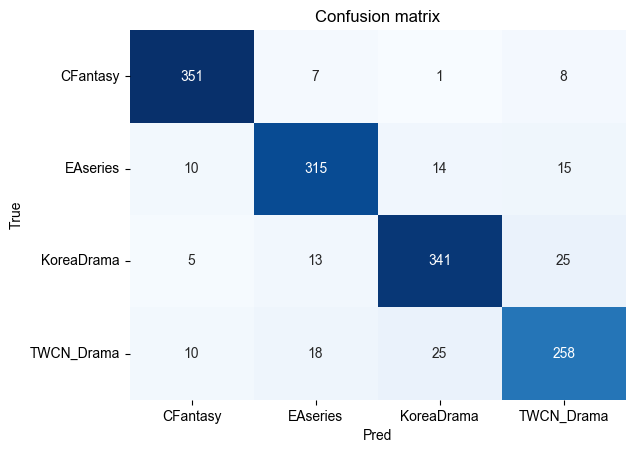

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 TF-IDF

改試試看使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果

這邊使用到的TfidfVectorizer 和 上週使用到的TfidfTransformer都是用來計算文本的TF-IDF，不同的是TfidfTransformer適用於已經計算好詞頻的情況。

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

,一位,一口氣,一句,一名,一場,一季,一家,一對,一年,一本,...,魔女,魔法,魷魚遊戲,麻煩,黑幫,黑暗,黑色,默契,鼓勵,龍天樓
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.119385,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.191495,0.0,0.0,0.0,0.0
3300,0.0,0.0,0.0,0.0,0.066570,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3301,0.0,0.0,0.0,0.0,0.099694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3302,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    CFantasy       0.94      0.96      0.95       367
    EAseries       0.91      0.92      0.91       354
  KoreaDrama       0.88      0.91      0.90       384
  TWCN_Drama       0.90      0.83      0.86       311

    accuracy                           0.91      1416
   macro avg       0.91      0.90      0.90      1416
weighted avg       0.91      0.91      0.91      1416



效果一樣也是不錯，可能因為不同語種/不同類型的劇、文章的四個版別 本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.08191013, 0.10294294, 0.10247707, 0.30796909, 0.10209799]),
 'score_time': array([0.01491809, 0.01814699, 0.02133608, 0.02031517, 0.01747918]),
 'test_f1_macro': array([0.90084172, 0.87717622, 0.88835763, 0.9107604 , 0.88591115]),
 'test_precision_macro': array([0.90194538, 0.87692917, 0.89145385, 0.91256386, 0.88512111]),
 'test_recall_macro': array([0.90001096, 0.87851588, 0.88727587, 0.91015756, 0.88721586])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    CFantasy       0.92      0.96      0.94       850
    EAseries       0.88      0.89      0.88       826
  KoreaDrama       0.91      0.89      0.90       962
  TWCN_Drama       0.86      0.83      0.85       666

    accuracy                           0.90      3304
   macro avg       0.89      0.89      0.89      3304
weighted avg       0.90      0.90      0.90      3304



## 4. 比較5個不同模型效果(Decision Tree、Logistic Regression、SVM、Random Forest、Multi-nomial-NB)

In [ ]:
# 定義模型訓練組合


def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

    CFantasy       0.92      0.96      0.94       850
    EAseries       0.88      0.89      0.88       826
  KoreaDrama       0.91      0.89      0.90       962
  TWCN_Drama       0.86      0.83      0.85       666

    accuracy                           0.90      3304
   macro avg       0.89      0.89      0.89      3304
weighted avg       0.90      0.90      0.90      3304



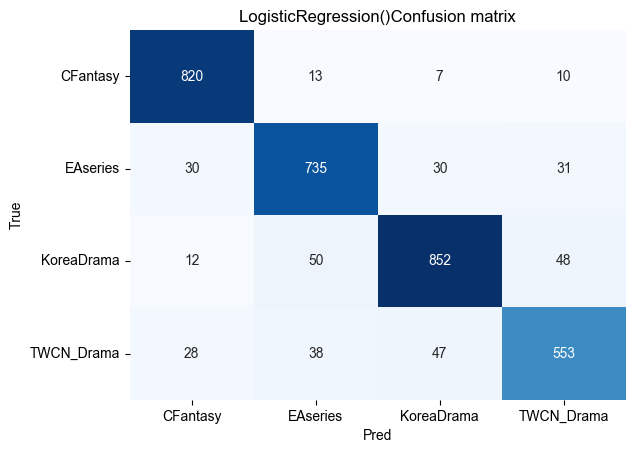

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

    CFantasy       0.92      0.96      0.94       850
    EAseries       0.88      0.89      0.88       826
  KoreaDrama       0.91      0.89      0.90       962
  TWCN_Drama       0.86      0.83      0.85       666

    accuracy                           0.90      3304
   macro avg       0.89      0.89      0.89      3304
weighted avg       0.90      0.90      0.90      3304

now training: clf_dtree
              precision    recall  f1-score   support

    CFantasy       0.89      0.90      0.89       850
    EAseries       0.77      0.77      0.77       826
  KoreaDrama       0.81      0.81      0.81       962
  TWCN_Drama       0.70      0.70      0.70       666

    accuracy                           0.80      3304
   macro avg       0.79      0.79      0.79      3304
weighted avg       0.80      0.80      0.80      3304

now training: clf_svm
              precision    recall  f1-score   support

  

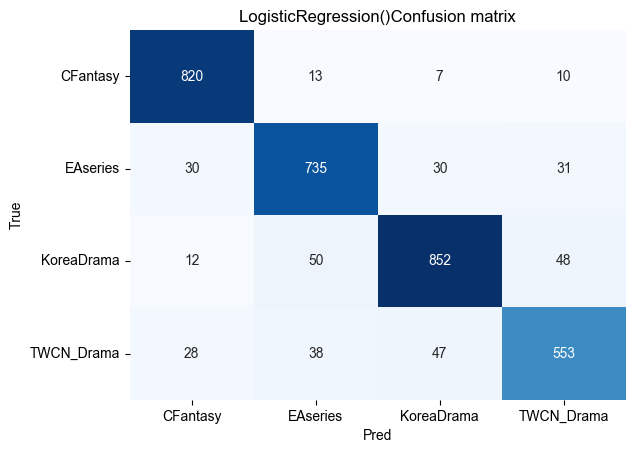

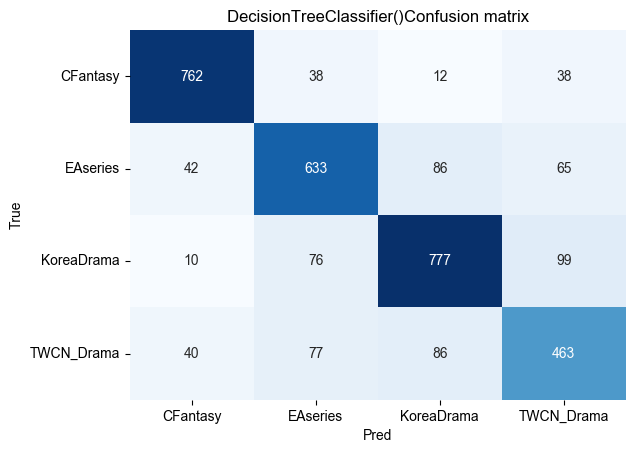

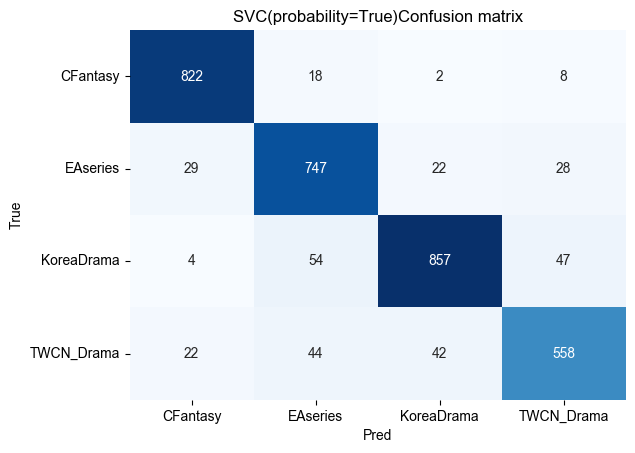

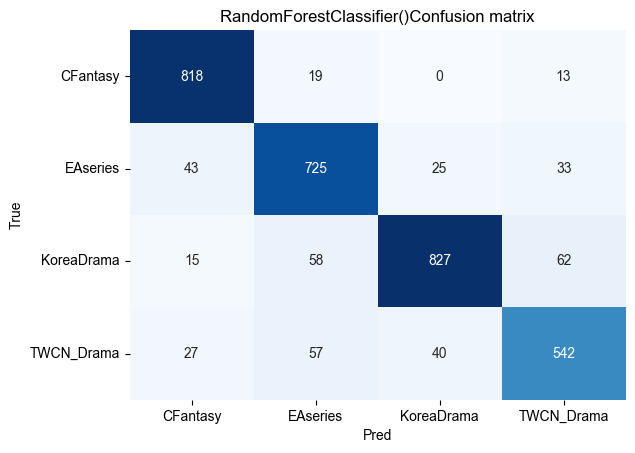

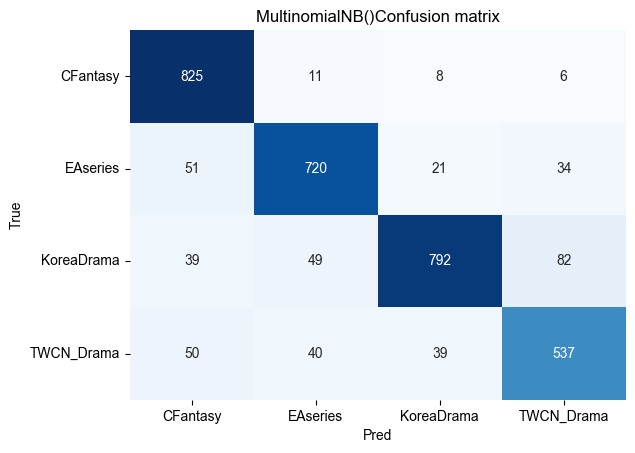

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) 
model_set['clf_rf'] = RandomForestClassifier()
model_set['clf_nb'] = MultinomialNB() #新增貝氏
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


分別觀察各個分類模型在不同類別的評估指標表現如何

In [ ]:
result_set['clf_logistic']

{'CFantasy': {'precision': 0.9213483146067416,
  'recall': 0.9647058823529412,
  'f1-score': 0.9425287356321839,
  'support': 850.0},
 'EAseries': {'precision': 0.8791866028708134,
  'recall': 0.8898305084745762,
  'f1-score': 0.8844765342960289,
  'support': 826.0},
 'KoreaDrama': {'precision': 0.9102564102564102,
  'recall': 0.8856548856548857,
  'f1-score': 0.8977871443624869,
  'support': 962.0},
 'TWCN_Drama': {'precision': 0.8613707165109035,
  'recall': 0.8303303303303303,
  'f1-score': 0.845565749235474,
  'support': 666.0},
 'accuracy': 0.8958837772397095,
 'macro avg': {'precision': 0.8930405110612172,
  'recall': 0.8926304017031833,
  'f1-score': 0.8925895408815434,
  'support': 3304.0},
 'weighted avg': {'precision': 0.8954884277390891,
  'recall': 0.8958837772397095,
  'f1-score': 0.8954434214538178,
  'support': 3304.0}}

+ 找出f1-score表現最好(看weighted avg)的模型是哪個，作為我們最終得到的分類器

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'CFantasy': {'f1-score': 0.9519397799652577,
              'precision': 0.9372862029646523,
              'recall': 0.9670588235294117,
              'support': 850.0},
 'EAseries': {'f1-score': 0.8845470692717584,
              'precision': 0.86558516801854,
              'recall': 0.9043583535108959,
              'support': 826.0},
 'KoreaDrama': {'f1-score': 0.9092838196286472,
                'precision': 0.9284940411700975,
                'recall': 0.8908523908523909,
                'support': 962.0},
 'TWCN_Drama': {'f1-score': 0.8538638102524866,
                'precision': 0.8705148205928237,
                'recall': 0.8378378378378378,
                'support': 666.0},
 'accuracy': 0.9031476997578692,
 'macro avg': {'f1-score': 0.8999086197795375,
               'precision': 0.9004700581865284,
               'recall': 0.9000268514326341,
               'support': 3304.0},
 'weighted avg': {'f1-score': 0.9029022470641211,
                  'precision

In [ ]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    CFantasy       0.94      0.96      0.95       367
    EAseries       0.90      0.93      0.92       354
  KoreaDrama       0.90      0.90      0.90       384
  TWCN_Drama       0.88      0.84      0.86       311

    accuracy                           0.91      1416
   macro avg       0.91      0.91      0.91      1416
weighted avg       0.91      0.91      0.91      1416



#### 我們可以自行測試一些玄幻武俠感的詞彙，看是否可以分類成功。

In [ ]:
model_set['clf_svm'].predict(vectorizer.transform(["穿越 黎明 魔法 毒物 藥草 武俠"]).toarray()) #分類結果是成功的！

array(['CFantasy'], dtype=object)

#### SVM成功分類

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘四個 model （Logistic、SVM、Random Forest、MultinomialNB）表現差不多。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的迴歸係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響

+ 這裡舉logistic regression + cv tokenizer 為例

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

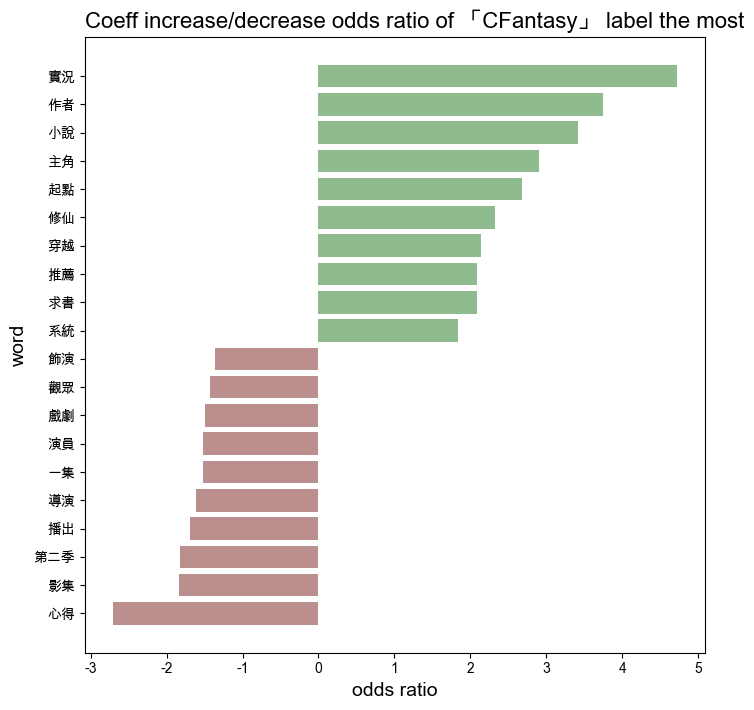

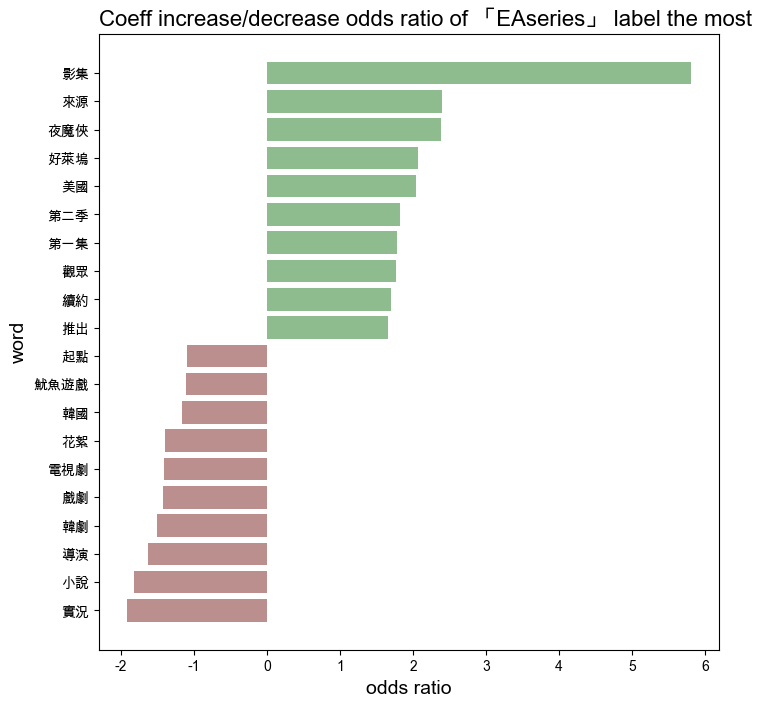

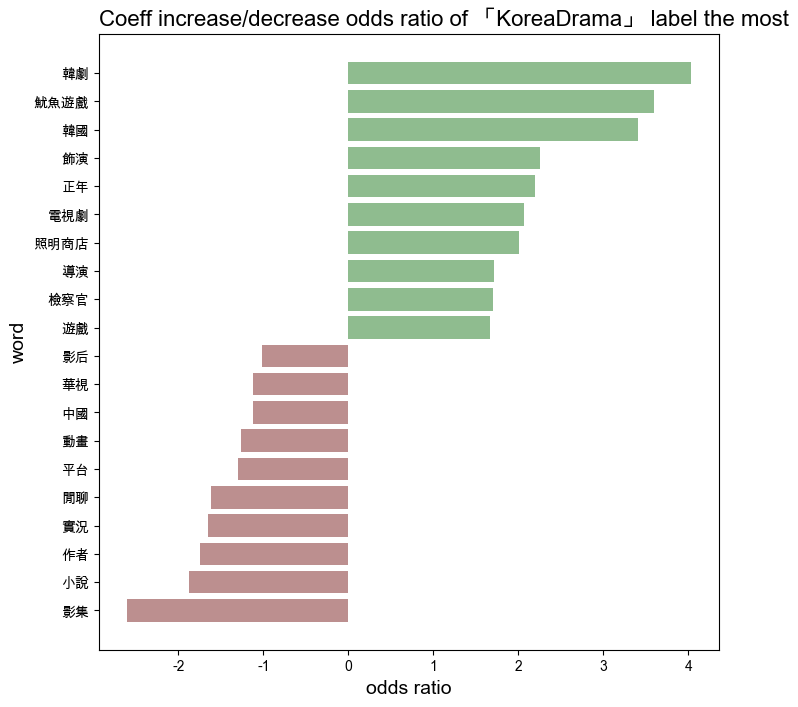

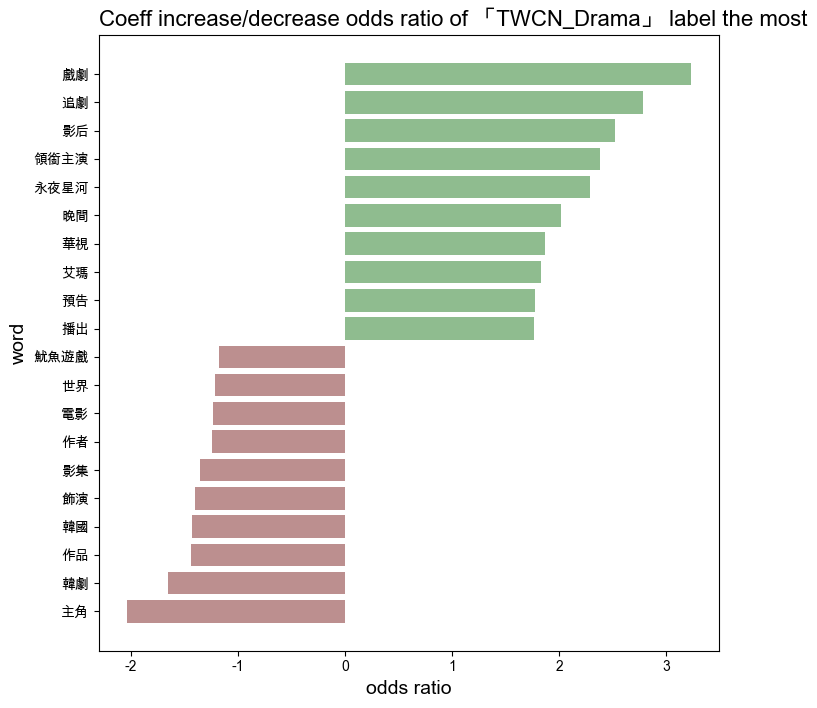

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「TWCN_Drama」中出現了戲劇、追劇、領街主演等與台劇收視與主角有關的關鍵字；而係數最低的字如主角、韓劇、作品則多與其他國家戲劇（如韓劇）有關，可能被模型視為負面關聯。

「KoreaDrama」中高係數的字如韓劇、韓國、鯊魚遊戲，皆為韓劇特有元素或代表作；而負相關的字如影集、小說、中國，則可能出現在其他類型文本中，降低模型對韓劇的預測信心。

「EAseries」高係數的字如影集、來源、夜魔俠、漫威，明確指向美劇與超級英雄作品；而負向詞如小說、韓劇、實況等可能干擾模型對歐美劇的判斷。

「CFantasy」中出現了實況、小說、修仙、穿越等關鍵字，呈現明顯的中國玄幻風格；而低係數字如心得、影集、播出則與一般戲劇評論或非虛構作品較為相關。

## 6. 用訓練好的分類器來預測其他家的新聞類別

我們前面使用ptt 四個版面 的資料訓練好了分類器模型，接著用其他時間段的資料試試看分類的效果。

`ptt_drama_final_test.csv` 為ptt相同版面於不同時間段的文章
- 版別：韓劇、台陸劇、玄幻、歐美劇
- 時間範圍：2024/04/05 ~ 2024/10/05

In [ ]:
drama_test = pd.read_csv("/Users/tungyuchen/Desktop/大學東東/4下/社媒/讀書會/raw_data/ptt_drama_final_test.csv")
# drama_test.dropna(inplace=True)
drama_test

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.171230424...,[心得]大理寺少卿遊(書劇雷)-02,2024-04-05 16:03:54,Auxo,TWCN_Drama,防雷頁防雷頁\n\n\n\n\n如果沒有特別說明，\n\n原作/動畫版李餅會稱貓爺，劇版李餅...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yu1314"", ""cm...",122.118.11.143,2024-04-06 01:06:48,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.171231249...,[LIVE]追風者33-36,2024-04-05 18:21:35,sonia16,TWCN_Drama,追劇日曆\nhttps://i.imgur.com/FWoYmv7.jpg\n大事件\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""robbile"", ""c...",118.166.192.87,2024-04-06 01:06:48,ptt
2,3,https://www.ptt.cc/bbs/China-Drama/M.171231637...,[閒聊]與鳳行ep34-39(超點大結局）,2024-04-05 19:26:12,fenpourpre,TWCN_Drama,貫穿全劇的兩個字「責任」\nhttps://i.imgur.com/lsPft5U.jpg\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""evitalee6937...",1.162.235.106,2024-04-06 01:06:48,ptt
3,4,https://www.ptt.cc/bbs/China-Drama/M.171232446...,[閒聊]最近好看短劇《難尋》《紅衣醉》,2024-04-05 21:40:58,millymilly66,TWCN_Drama,近期的短劇相對好看多了\n 不過好像沒人討論剛上檔的這兩部\n\n ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""neehsup17gst...",180.148.3.200,2024-04-06 01:06:48,ptt
4,5,https://www.ptt.cc/bbs/China-Drama/M.171239556...,[閒聊]〈又見逍遙〉EP11-20LIVE,2024-04-06 17:26:07,grabbitreen,TWCN_Drama,隱龍窟戰蛇妖、白河寨鬥鬼將軍，兩場打戲非常熱血，期待後面集數有更精彩的戰鬥!!\n又見逍遙\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""royroy666"", ...",114.46.41.104,2024-04-07 01:06:40,ptt
...,...,...,...,...,...,...,...,...,...,...,...
5241,77a2c293-10b7-4ae4-9f96-415e968d98b3,https://www.ptt.cc/bbs/CFantasy/M.1728039007.A...,Re: [討論] YY小說穿越到古中國總是想弄出活版印刷,2024-10-04,Swampert,CFantasy,騙個P幣 不然打一堆字\n\n: 推 frank0927 : 推君主立憲...很可能會不...,"→ hdjj : 以前為了化肥,還有所謂的鳥糞戰爭,那可是珍稀資源 10/04...",NaN,2025-04-16T23:22:12.556222,ptt
5242,058c0b3b-cc7b-455b-b762-ebab247cd326,https://www.ptt.cc/bbs/CFantasy/M.1728053458.A...,[推薦] 全能大畫家,2024-10-04,Minaiya,CFantasy,起點\n\n全能大畫家\n\n怎麼說呢 我大概一年前看這本 當時就很好奇 版上為什麼幾乎看不...,推 urrusa7 : 因為賞畫的門檻比較高吧 大概 10/04 23:06\n→ ...,NaN,2025-04-16T23:22:13.408746,ptt
5243,88befae5-6c08-40a4-a22f-9525f1d01f56,https://www.ptt.cc/bbs/CFantasy/M.1728058226.A...,[公告] 關於「YY小說穿越到古中國總....」討論串,2024-10-05,cuteker,CFantasy,查本板「YY小說穿越到古中國總是想弄出活版印刷」討論串，\n\n已無關本板討論方向，後續無關...,NaN,NaN,2025-04-16T23:22:14.197581,ptt
5244,9b1001ae-2862-473d-b3d4-b790014f6ac7,https://www.ptt.cc/bbs/CFantasy/M.1728099770.A...,[求書] 想找類似生活系遊戲的書,2024-10-05,clv,CFantasy,其實是想找生活類 真的種田養魚趕海 可以有外卦 但不要沒限制的那種\n\n價值觀正常\...,推 sss86616 : 五噸 有開新書 非正常美食文 又回歸料理了 10/05 1...,NaN,2025-04-16T23:22:14.988138,ptt


In [ ]:
# 過濾 nan 的資料
drama_test = drama_test.dropna(subset=['artTitle'])
drama_test = drama_test.dropna(subset=['artContent'])
# 移除網址格式
drama_test["artContent"] = drama_test.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
drama_test["artTitle"] = drama_test["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
drama_test["artContent"] = drama_test.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
drama_test["artTitle"] = drama_test["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
drama_test.head(3)
# 留下 content
drama_test["content"] = drama_test["artTitle"] + drama_test["artContent"]
drama_test = drama_test[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
drama_data.head()
# 看看有幾篇文章
print(f"total docs: {drama_test.shape[0]}")


total docs: 5241


In [ ]:
# # 移除網址格式
# drama_test["artContent"].str.replace("(http|https)://.*", "", regex=True)
# drama_test["artTitle"].str.replace("(http|https)://.*", "", regex=True)
# drama_test["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
# drama_test["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# # 留下 content
# drama_test["content"] = drama_test["artTitle"] + drama_test["artContent"]
# drama_test = drama_test.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 fundrama_testion
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

drama_test["words"] = drama_test["content"].apply(getToken).map(" ".join)
drama_test.head()

,content,artUrl,artCatagory,words
0,心得大理寺少卿遊書劇雷防雷頁防雷頁如果沒有特別說明原作動畫版李餅會稱貓爺劇版李餅稱餅爺這篇基...,https://www.ptt.cc/bbs/China-Drama/M.171230424...,TWCN_Drama,心得 大理寺少卿遊 書劇雷 防雷 防雷 特別 原作 動畫版 李餅 貓爺 劇版 李餅 餅爺 這...
1,追風者追劇日曆大事件已發生的前面文貼過了不再贅述下面應該是假幣案今晚有兩場直播開始一小時的桃...,https://www.ptt.cc/bbs/China-Drama/M.171231249...,TWCN_Drama,追風者 追劇 日曆 事件 文貼過 贅述 假幣 今晚 兩場 直播 小時 桃廠 通告 晚點 聊還...
2,閒聊與鳳行超點大結局貫穿全劇的兩個字責任王爺的爸爸媽媽要出來啦短短三個禮拜時間過真快想當初第...,https://www.ptt.cc/bbs/China-Drama/M.171231637...,TWCN_Drama,閒聊 與鳳行 超點 大結局 貫穿 全劇 兩個 責任 王爺 爸爸媽媽 短短 三個 禮拜 時間 ...
3,閒聊最近好看短劇難尋紅衣醉近期的短劇相對好看多了不過好像沒人討論剛上檔的這兩部第一部是趙奕欽...,https://www.ptt.cc/bbs/China-Drama/M.171232446...,TWCN_Drama,閒聊 好看 短劇 難尋 紅衣 近期 短劇 好看 討論 剛上 兩部 第一部 欽演 難尋 第一次...
4,閒聊又見逍遙隱龍窟戰蛇妖白河寨鬥鬼將軍兩場打戲非常熱血期待後面集數有更精彩的戰鬥又見逍遙新的...,https://www.ptt.cc/bbs/China-Drama/M.171239556...,TWCN_Drama,閒聊 又見逍遙 隱龍窟 戰蛇 白河 鬥鬼 將軍 兩場 打戲 熱血 期待 集數 精彩 又見逍遙...


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords

with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    stopwords_manual = ["一直", "之後", "XD", "The", "感覺", "發現", "無法", "本劇","過去","這部","講述","成為","知道","12","現在","這種","出現","發生","看完","看到","那篇","一部","一半","一堆","看成","第季","有人"]
    stopWords.extend(stopwords_manual)
jieba.load_userdict('./dict/Drama_dict.txt')


Building prefix dict from /Users/tungyuchen/Desktop/大學東東/4下/社媒/讀書會/dict/dict.txt.big ...
Loading model from cache /var/folders/hq/4zsyf1dd77d29jc_2rbxgg9w0000gn/T/jieba.ua5607fea198329e7e8049a7d96c66235.cache


Loading model cost 1.825 seconds.
Prefix dict has been built successfully.


觀察一下資料集的分佈狀況

In [ ]:
drama_test['artCatagory'].value_counts()

artCatagory
EAseries      1405
KoreaDrama    1377
CFantasy      1321
TWCN_Drama    1138
Name: count, dtype: int64

將test集的資料與標籤進行對應，接著開始用先前訓練好的最好模型進行分類任務

In [ ]:
# # mapper = {"財經":"股市", "政治":"兩岸", "體育":"運動", "兩岸": "兩岸", "國際":"全球"}
# # drama_test['artCatagory'] = drama_test['artCatagory'].map(mapper)

X = drama_test['words']
y = drama_test['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())

# print(classification_report(y, y_pred))

from sklearn.metrics import classification_report

labels = sorted(list(set(y)))  # 假設你已確認 y 和 y_pred 都是這幾類
print(classification_report(y, y_pred, labels=labels))





              precision    recall  f1-score   support

    CFantasy       0.89      0.95      0.92      1321
    EAseries       0.81      0.87      0.84      1405
  KoreaDrama       0.80      0.80      0.80      1377
  TWCN_Drama       0.74      0.60      0.67      1138

    accuracy                           0.81      5241
   macro avg       0.81      0.81      0.81      5241
weighted avg       0.81      0.81      0.81      5241



從classification report可以發現，在同樣版別但不同時間段的資料集上，前面訓練得到的分類器在這邊表現尚可
weighted avg 的f1-score有0.81，但我們可以接著進一步研究分類的結果。

In [ ]:
drama_test['pred'] = y_pred
drama_test.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,心得 大理寺少卿遊 書劇雷 防雷 防雷 特別 原作 動畫版 李餅 貓爺 劇版 李餅 餅爺 這...,TWCN_Drama,TWCN_Drama
1,追風者 追劇 日曆 事件 文貼過 贅述 假幣 今晚 兩場 直播 小時 桃廠 通告 晚點 聊還...,TWCN_Drama,TWCN_Drama
2,閒聊 與鳳行 超點 大結局 貫穿 全劇 兩個 責任 王爺 爸爸媽媽 短短 三個 禮拜 時間 ...,TWCN_Drama,EAseries
3,閒聊 好看 短劇 難尋 紅衣 近期 短劇 好看 討論 剛上 兩部 第一部 欽演 難尋 第一次...,TWCN_Drama,TWCN_Drama
4,閒聊 又見逍遙 隱龍窟 戰蛇 白河 鬥鬼 將軍 兩場 打戲 熱血 期待 集數 精彩 又見逍遙...,TWCN_Drama,TWCN_Drama
...,...,...,...
5241,討論 小說 穿越 中國 活版印刷 騙個幣 推推 君主立憲 政治 正確 君主立憲 回答 文中 ...,CFantasy,CFantasy
5242,推薦 全能大畫家 起點 全能大畫家 一年 這本 好奇 版上 看不到 推薦 半年 最新 進度 ...,CFantasy,CFantasy
5243,公告 小說 穿越 中國 討論 串查 本板 小說 穿越 中國 活版印刷 討論 無關 本板 討論...,CFantasy,CFantasy
5244,求書想 類似 生活 遊戲 生活 真的 種田 養魚 趕海 有外 那種 價值觀 打死 日本 美帝...,CFantasy,CFantasy


將錯誤分類的結果篩選出來

In [ ]:
false_pred = drama_test.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
2,閒聊 與鳳行 超點 大結局 貫穿 全劇 兩個 責任 王爺 爸爸媽媽 短短 三個 禮拜 時間 ...,TWCN_Drama,EAseries
6,閒聊 與鳳行 那束 台詞 關聯 猜析 那束 陽光 行止 沈璃為 靈界 力戰 魑魅 涅槃 東海...,TWCN_Drama,EAseries
8,心得 玉樓春 追白鹿 劇但 只好 早期 片名 還以 劇片 主題 愛情 服裝 整體 劇景 時代...,TWCN_Drama,KoreaDrama
24,閒聊 又見逍遙 遊戲 終於 京城 好久 打戲 飛賊 打戲 很虛 文戲 鋪陳 別具匠心 解鎖 ...,TWCN_Drama,KoreaDrama
28,承歡記 該劇 同名 改編 上海 女孩 承歡 男友 辛家 亮議 辛家 經濟 條件 感情 關係 ...,TWCN_Drama,KoreaDrama
...,...,...,...
5083,閒聊 誰讓他修仙的 月初 月票 抽獎 公布 月初 白鴉 月票 抽獎 活動 白鴉 豆豆 仙子 ...,CFantasy,EAseries
5093,原創 大荒 遺冊 太平 懸案 尋蹤 角川 懸案 尋蹤 網頁 讀版 未時 縣衙 公堂 縣令 焦...,CFantasy,EAseries
5153,閒聊 消失 套路 想發 這篇文 群裡 聊到 早年 固定橋 原因 消失 說滅 美的 那種 經典...,CFantasy,EAseries
5201,閒聊 類似 蓋世 雙諧 味道 最重 那段 劇情 新聞 吃過飯 建議 味道 真的 防雷 第一 ...,CFantasy,TWCN_Drama


觀察看看實際為韓劇版，但模型分類錯誤的內容長怎麼樣。

In [ ]:
false_pred.loc[false_pred['artCatagory']=='KoreaDrama', :].head(20)

,words,artCatagory,pred
2088,心得 淚之女王 一股 煩躁 如題 老婆 淚之女王 推說 好看 感人 第三集 之有 滿滿的 尷...,KoreaDrama,TWCN_Drama
2094,篡位 一集 配樂 主題曲 配樂 三首 主題曲 一首 搜尋 一首 開頭 謝謝,KoreaDrama,EAseries
2098,閒聊 七人的復活 順玉繼 上流 戰爭 成功 去年 推出 七人 逃脫 原本 狗血 保證 沒想到...,KoreaDrama,EAseries
2099,閒聊 殺人者的購物中心 全劇 李棟旭 頹喪 叔叔 模樣 圈粉 男主死 穿插 回憶 女主還 武...,KoreaDrama,TWCN_Drama
2106,心得 寄生獸 普雷日 韓兩版 防雷 一二三四五六七八九十 開門見山 喜歡 日版 原因 循序漸...,KoreaDrama,CFantasy
2107,心得 網飛 寄生獸 灰色 部隊 第一季 先說 結論 看過 寄生獸 相關 作品 影集 精彩 網...,KoreaDrama,EAseries
2112,寄生獸 灰色 部隊 第集 有雷 初次 發文 格式 怪怪 請見 原作 書粉 原作 設定 記沒 ...,KoreaDrama,TWCN_Drama
2113,心得 寄生獸 觀後 心得 心得 大部份 韓版 缺點 分享 心得 結尾 只能 震撼 幾次 結尾...,KoreaDrama,TWCN_Drama
2118,淚之女王 結尾 音樂 無雷 請問 預告 這段 好好,KoreaDrama,EAseries
2119,閒聊 小吐槽 與惡魔有約 有雷 真的 宋江 顏值 撐起 劇看 第一集 先猜 結局 宋江 復活...,KoreaDrama,TWCN_Drama


挑選一篇韓劇版的文章觀察看看內容，看為何模型會將其分類成玄幻的內容

In [ ]:
pprint(false_pred['words'][2106])

('心得 寄生獸 普雷日 韓兩版 防雷 一二三四五六七八九十 開門見山 喜歡 日版 原因 循序漸進 過程 安排 完整 主角 剛被 寄生 慢慢 寄生獸 寄生獸 '
 '融入 社會 只會 慢慢 融入 社會 寄生獸 寄生獸 不吃 導入 主角 戰鬥能力 寄生獸 變強 設定 級別 寄生獸 省略 太多 省略 設定 感情 戰術 '
 '主角 寄生獸 暫時 分離 日版 寄生獸 壓迫感 較強 韓版 霰彈槍 能幹 寄生獸 韓版 單調 寄生獸 組織 莫名 韓版 寄生獸 實力 像是 惡靈古堡 '
 '裡的 舔爺 瀕臨絕種 舔爺 人類 部隊 完虐 寄生獸 劇情 寄生獸 生存 還在 內部 大屠殺 團結 生存 更久 背叛 稍微 砍死 還算 隊友 殺光 '
 '吃錯藥 隊友 死光 位置 自我 繁殖')


模型對該篇韓劇版文章的預測結果出現誤判，將其分類為「CFantasy」而非「KoreaDrama」。觀察內容可發現，雖然該文討論的是韓國改編的《寄生獸》，但大量出現如「寄生獸」、「惡靈古堡」、「舔爺」、「戰鬥能力」、「變強」、「生存」、「大屠殺」、「繁殖」等玄幻、末日或戰鬥相關字眼，與中國玄幻文常見主題相似，導致模型誤以為為「CFantasy」文本。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。

### 補充-視覺化模型訓練表現

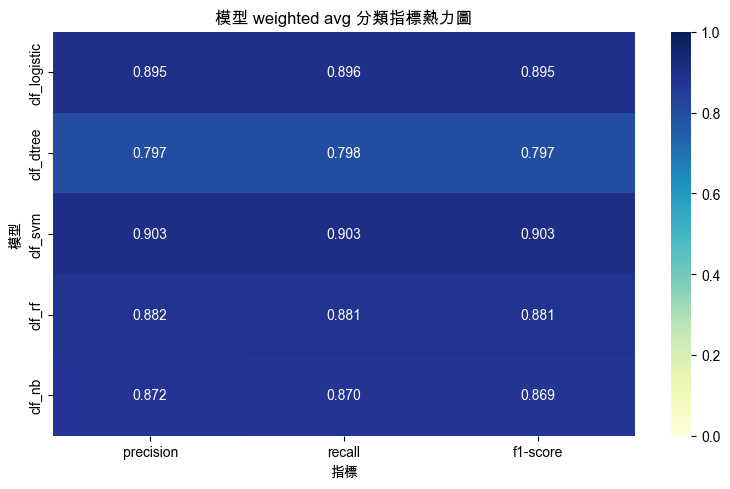

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 準備資料
metrics = ['precision', 'recall', 'f1-score']
model_names = list(result_set.keys())

# 建立 DataFrame 儲存模型指標值
heatmap_data = pd.DataFrame(index=model_names, columns=metrics)

for model in model_names:
    for metric in metrics:
        heatmap_data.loc[model, metric] = result_set[model]['weighted avg'][metric]

# 轉成 float 型別
heatmap_data = heatmap_data.astype(float)

# 繪圖
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".3f")
plt.title("模型 weighted avg 分類指標熱力圖")
plt.ylabel("模型")
plt.xlabel("指標")
plt.tight_layout()
plt.show()


## 第九週：主題模型（中文） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
這次課程分為幾個部分：
1. 將資料進行前處理 
2. lexicon-based 的主題模型
3. LDA 主題模型 
4. 視覺化主題模型 
5. GuidedLDA
6. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.font_manager as fm


In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定文字雲中文字體路徑
font_path = "raw_data/SourceHanSansTW-Regular.otf"

# 1) 將字體檔案加入到 matplotlib 的字體庫
fm.fontManager.addfont(font_path)

# 2) 建立 FontProperties 物件
fprop = fm.FontProperties(fname=font_path)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
# 字型設定：使用 Source Han Sans TW
font_path = "raw_data/SourceHanSansTW-Regular.otf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [font_name]
plt.rcParams['axes.unicode_minus'] = False

## 2. 資料前處理

In [ ]:
udn = pd.read_csv("raw_data/ptt_5topics.csv")  # 匯資料
udn.head(3)

,system_id,artID,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,insertedDate,dataSource
0,0,1,https://www.ptt.cc/bbs/fastfood/M.1744612474.A...,[情報] 好康分享! 肯德基/必勝客優惠券整理,2025-04-14 14:34:32,ya871121 (一圓好運),fastfood,肯德基/必勝客優惠券整理分享~\n\nhttps://i.imgur.com/BPgEfe9...,"[{'cmtStatus': '推', 'cmtPoster': 'RuruX5566', ...",2025-04-18 21:30:04,ptt
1,1,2,https://www.ptt.cc/bbs/fastfood/M.1744616740.A...,[新聞] 麥當勞鬆餅堡「台灣將再開賣」 業者證實：這天上市,2025-04-14 15:45:35,chinaeatshit (我愛台灣！中國吃屎！！),fastfood,麥當勞鬆餅堡「台灣將再開賣」 業者證實：這天上市\n\nhttps://news.tvbs....,"[{'cmtStatus': '推', 'cmtPoster': 'XD15041', 'c...",2025-04-18 21:30:05,ptt
2,2,3,https://www.ptt.cc/bbs/fastfood/M.1743562489.A...,[討論] 爺爺卡拉雞1送1還行嗎？,2025-04-02 10:54:47,ez910115 (小隻黑黑),fastfood,只限今天，要去app領卷\n卡拉雞一送一\n可是還沒吃過莎莎卡拉，快到期了\n看價錢又有點猶...,"[{'cmtStatus': '→', 'cmtPoster': 'joan33235', ...",2025-04-18 21:30:10,ptt


In [ ]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,肯德基必勝客優惠券整理分享優惠可以使用以下連結,https://www.ptt.cc/bbs/fastfood/M.1744612474.A...,fastfood,2025-04-14 14:34:32
1,麥當勞鬆餅堡台灣將再開賣業者證實這天上市記者陳昫蓁報導麥當勞厚鬆餅堡系列一上市立刻引起搶購熱...,https://www.ptt.cc/bbs/fastfood/M.1744616740.A...,fastfood,2025-04-14 15:45:35
2,只限今天要去領卷卡拉雞一送一可是還沒吃過莎莎卡拉快到期了看價錢又有點猶豫,https://www.ptt.cc/bbs/fastfood/M.1743562489.A...,fastfood,2025-04-02 10:54:47


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")
custom_words = ["蓮花樓","長相思","笛飛聲","緯來"]

for word in custom_words:
    jieba.add_word(word)
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn = udn[udn["content"].notna()]  # 移除 content 欄為 NaN 的列
udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /home/tingyu/SMA_2025S/week09/dict/dict.txt.big ...
2025-04-19 22:48:43,172 : DEBUG : Building prefix dict from /home/tingyu/SMA_2025S/week09/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ubb965d94a3e56985054de3cd4e75aeb6.cache
2025-04-19 22:48:43,175 : DEBUG : Loading model from cache /tmp/jieba.ubb965d94a3e56985054de3cd4e75aeb6.cache
Loading model cost 1.104 seconds.
2025-04-19 22:48:44,278 : DEBUG : Loading model cost 1.104 seconds.
Prefix dict has been built successfully.
2025-04-19 22:48:44,280 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,肯德基必勝客優惠券整理分享優惠可以使用以下連結,https://www.ptt.cc/bbs/fastfood/M.1744612474.A...,速食,2025-04-14 14:34:32,"[肯德基, 必勝客, 優惠券, 整理, 分享, 優惠, 使用, 以下, 連結]"
1,麥當勞鬆餅堡台灣將再開賣業者證實這天上市記者陳昫蓁報導麥當勞厚鬆餅堡系列一上市立刻引起搶購熱...,https://www.ptt.cc/bbs/fastfood/M.1744616740.A...,速食,2025-04-14 15:45:35,"[麥當勞, 鬆餅, 台灣將, 開賣, 業者, 證實, 這天, 上市, 記者, 報導, 麥當勞..."
2,只限今天要去領卷卡拉雞一送一可是還沒吃過莎莎卡拉快到期了看價錢又有點猶豫,https://www.ptt.cc/bbs/fastfood/M.1743562489.A...,速食,2025-04-02 10:54:47,"[今天, 領卷, 卡拉, 雞一送, 沒吃過, 莎莎, 卡拉, 到期, 價錢, 有點, 猶豫]"
3,吉野家降價了逾款餐點最高現省元新菜單出爐日本連鎖丼飯店包含松屋家今年月陸續喊漲漲幅最高元不過...,https://www.ptt.cc/bbs/fastfood/M.1743568712.A...,速食,2025-04-02 12:38:30,"[吉野家, 降價, 逾款, 餐點, 最高, 現省, 菜單, 出爐, 日本, 連鎖, 飯店, ..."
4,屯的漢堡王電子票券一個禮拜多前還能用剛剛去換每張櫃檯刷都顯示過期漢堡王是擺明要不認帳是不是那...,https://www.ptt.cc/bbs/fastfood/M.1743573159.A...,速食,2025-04-02 13:52:36,"[漢堡, 電子, 票券, 禮拜, 多前, 還能, 剛剛, 去換, 每張, 櫃檯, 顯示, 過..."


In [ ]:
# 加入你自己發現的停用詞（可隨時擴充）
extra_stopwords = {
    '一下', '一定', '一直', '一起', '一點', '不能', '不錯', '之前', '之後', '今天',
    '以上', '以下', '使用', '來說', '內容', '分享', '原本', '只能', '可能', '問題',
    '喜歡', '好像', '完全', '已經', '希望', '很多', '心得', '感覺', '應該', '提供',
    '搭配', '方式', '時間', '更多', '最後', '最近', '有點', '比較', '沒有', '現在',
    '發現', '目前', '直接', '看到', '看看', '真的', '知道', '覺得', '這次', '那種',
    '剛剛','道路','需要','一次','上次','一支','謝謝', '部分','地方' ,'一些' ,'整個',
    '兩個' ,'這是','整理','連結','內部','公布'
}

# 合併並轉為 set（效率更高）
stopWords = set(stopWords).union(extra_stopwords)


In [ ]:
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    return [w for w in seg_list if w not in stopWords and len(w) > 1]


In [ ]:
udn = udn[udn["content"].notna()]
udn["words"] = udn["content"].apply(getToken)

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words
0,肯德基必勝客優惠券整理分享優惠可以使用以下連結,https://www.ptt.cc/bbs/fastfood/M.1744612474.A...,速食,2025-04-14 14:34:32,"[肯德基, 必勝客, 優惠券, 優惠]"
1,麥當勞鬆餅堡台灣將再開賣業者證實這天上市記者陳昫蓁報導麥當勞厚鬆餅堡系列一上市立刻引起搶購熱...,https://www.ptt.cc/bbs/fastfood/M.1744616740.A...,速食,2025-04-14 15:45:35,"[麥當勞, 鬆餅, 台灣將, 開賣, 業者, 證實, 這天, 上市, 記者, 報導, 麥當勞..."
2,只限今天要去領卷卡拉雞一送一可是還沒吃過莎莎卡拉快到期了看價錢又有點猶豫,https://www.ptt.cc/bbs/fastfood/M.1743562489.A...,速食,2025-04-02 10:54:47,"[領卷, 卡拉, 雞一送, 沒吃過, 莎莎, 卡拉, 到期, 價錢, 猶豫]"
3,吉野家降價了逾款餐點最高現省元新菜單出爐日本連鎖丼飯店包含松屋家今年月陸續喊漲漲幅最高元不過...,https://www.ptt.cc/bbs/fastfood/M.1743568712.A...,速食,2025-04-02 12:38:30,"[吉野家, 降價, 逾款, 餐點, 最高, 現省, 菜單, 出爐, 日本, 連鎖, 飯店, ..."
4,屯的漢堡王電子票券一個禮拜多前還能用剛剛去換每張櫃檯刷都顯示過期漢堡王是擺明要不認帳是不是那...,https://www.ptt.cc/bbs/fastfood/M.1743573159.A...,速食,2025-04-02 13:52:36,"[漢堡, 電子, 票券, 禮拜, 多前, 還能, 去換, 每張, 櫃檯, 顯示, 過期, 漢..."


## 3. Lexicon-based / 人工給定主題的主題模型

artCatagory
- China-Drama    990
- Interior       971
- BabyMother     952
- fastfood       572
- Road           519
- MakeUp         442

In [ ]:
udn["artCatagory"] = udn["artCatagory"].replace('fastfood','速食')
udn["artCatagory"] = udn["artCatagory"].replace('MakeUp','美妝')
udn["artCatagory"] = udn["artCatagory"].replace('Interior','裝潢')
udn["artCatagory"] = udn["artCatagory"].replace('Road','道路')
udn["artCatagory"] = udn["artCatagory"].replace('BabyMother','育嬰')
udn["artCatagory"] = udn["artCatagory"].replace('China-Drama','陸劇')
udn['artCatagory'].unique()

array(['速食', '陸劇', '裝潢', '道路', '育嬰', '美妝'], dtype=object)

In [ ]:
udn['artCatagory'].value_counts()

artCatagory
陸劇    988
裝潢    970
育嬰    951
速食    571
道路    519
美妝    442
Name: count, dtype: int64

#### 用各個主題常見的詞來作為主題的代表詞

In [ ]:
## 定義主題
fastfood_cnt = udn.loc[udn['artCatagory'] == '速食',:]['words'].explode().value_counts().head(300)
pprint(" ".join(fastfood_cnt.index))

('優惠 麥當勞 漢堡 套餐 肯德基 口味 炸雞 薯條 起司 比薩 味道 代碼 雞塊 推出 雞腿 麥克 單點 日期 日本 價格 飲料 限定 披薩 摩斯 牛肉 '
 '餐點 好吃 鬆餅 台灣 口感 系列 原味 店員 優惠券 外帶 可樂 原價 必勝客 經典 甜心 餐廳 分店 活動 期間 風味 表示 選擇 產品 紅茶 整體 '
 '高度 速食店 豬肉 辣味 美式 雙層 酥脆 推薦 草莓 商品名稱 有人 今年 特價 評分 明太子 早餐 蛋撻 報導 點餐 華堡 雞肉 廠商 兌換 門市 '
 '烤雞 洋蔥 最高 外送 特別 台北 網友 美國 黃金 份量 食材 鱈魚 速食 霸堡 價值 開賣 新品 鮭魚 拿到 生菜 綠茶 大小 點心 記者 升級 '
 '滋味 玉米濃湯 歡樂 相關 得來 薯餅 新聞 櫃檯 牛堡 冰淇淋 點數 夏威夷 主管 數位 顧客 搖搖 聯名 算是 業者 購買 紙包 奶昔 有沒有 小元 '
 '飲品 分鐘 百事可樂 綁定 雙拼 上校 甜辣 官網 機會 奶油 魷魚 員工 安格斯 醬汁 品牌 蛋塔 實體 海鮮 出現 包裝 會員 東西 蕃茄醬 韓風 '
 '裡面 自助 客人 請問 德腸 一口 面積 地瓜 店家 不到 以前 回歸 燒肉 雞汁 包含 蜂蜜 煙燻 花椒 內用 組合 醬料 售完 胡椒 冰無糖 供應 '
 '消費者 盎司 為止 公司 商品 限時 丹丹 取餐 消費 小薯 上面 滿分 總匯 漲價 莎莎卡 火山 濃郁 服務 調整 無敵 進行 無法 兒童 附上 打開 '
 '顯示 雞堡 檸檬 買一送一 超過 火腿 類似 官方 朋友 上市 鮮菇 日式 一名 現場 變成 超級 不用 照片 加量 結束 完整 限量 楓糖 營業 去年 '
 '價位 美味 品項 韓式 結帳 序號 加價 蘑菇 還蠻 番茄醬 焦糖 用餐 番茄 獲得 中薯 重新 即可 中午 咖啡 處理 地址 嚐鮮 指定 章魚燒 說明 '
 '實際 四小 相當 遇到 記得 雙人 昨天 連鎖 豬堡 廣告 引述 平台 免費 特利 一份 點餐機 消息 似乎 事件 開放 手機 成功 中杯 比例 下去 '
 '台幣 香魚 近日 巧克力 宣布 一包 超值 組成 排隊 正式 餅乾 吃過 盒顆 派對 年月日 左右 至少 數量 日圓 多汁 小杯 印象 包括 便宜 發生 '
 '吉司 辣醬 指出')


In [ ]:
MakeUp_cnt = udn.loc[udn['artCatagory'] == '美妝',:]['words'].explode().value_counts().head(300)
pprint(" ".join(MakeUp_cnt.index))

('顏色 腮紅 眼影 唇膏 蜜粉 適合 粉底 效果 推薦 色號 質地 粉底液 產品 自然 日本 粉餅 防曬 膚色 容易 打亮 光澤 皮膚 彩妝 品牌 定妝 '
 '睫毛 這支 明顯 臉上 這款 氣墊 持久 睫毛膏 東西 好看 保濕 底妝 質感 提亮 超級 這盤 毛孔 特別 植村秀 肌膚 想要 氣色 入手 出門 夏天 '
 '粉色 眉毛 上妝 粉撲 影片 化妝 這顆 眼線 顯色 粉質 便宜 包裝 保養 珠光 控油 眼下 系列 專櫃 有沒有 整體 試色 簡單 朋友 眼線液 台灣 '
 '愛用 霧面 妝感 噴霧 眼妝 乾淨 有人 不用 以前 妝容 修飾 回購 嘴唇 手上 單色 潤色 亮片 選手 黑眼圈 平常 暈染 建議 可愛 日常 眉筆 '
 '開架 細緻 今年 妝前 手邊 方便 透明 打底 用到 價格 上班 試用 拿來 我會 重點 唇彩 版友 口紅 稍微 照片 參考 不好 服貼 每次 淚溝 '
 '年度 請問 這塊 均勻 櫃姐 購買 滋潤 實際 卸妝 一整天 這罐 眼睛 變得 購入 狀況 官網 漂亮 缺點 下來 混合 精華 紫色 感受 紅色 像是 '
 '相當 一點點 選擇 用過 習慣 實在 持妝 第一次 記得 冬天 遮瑕膏 不到 算是 好用 成分 之外 試試看 小時 沒什麼 光澤感 陣子 程度 試試 '
 '最愛 眼皮 當時 兩款 修容 擦起來 手指 介紹 滿意 更好 成膜 限定 味道 韓國 輕薄 變成 尤其 燒到 妝效 表現 厲害 類似 主要 用量 根本 '
 '上面 興趣 後續 有用 精緻 以後 棕色 清爽 香奈兒 刷子 完美 值得 歡迎 粉嫩 嘗試 脫妝 天氣 通常 美妝 常用 牌子 每天 不夠 差異 意外 '
 '玫瑰 唯一 辦法 靠櫃 膏體 資生堂 暗沉 舊版 橘色 斑駁 擔心 臉頰 泛紅 還好 色調 活動 一盤 回家 還會 胎嘎厚 感謝 素顏 推開 屬於 考慮 '
 '化妝品 新版 不太 設計 步驟 小心 哈哈哈 溫柔 一層 舒服 防水 評價 裡面 關係 奶油 下面 無法 厚重 呈現 出油 唇色 調色 氣質 膚質 遇到 '
 '重要 推出 猶豫 隨便 瑕疵 原因 膚況 再來 確定 不想 上唇 我用 海綿 當初 瑕度 文章 完成 櫃上 快速 優點 再用 幾個 黑色 狀態 討論 '
 '香味 氛圍')


In [ ]:
Interior_cnt = udn.loc[udn['artCatagory'] == '裝潢',:]['words'].explode().value_counts().head(300)
pprint(" ".join(Interior_cnt.index))

('房屋 裝潢 報價 需求 說明 內信 預算 地點 案件 格局 類型 聯絡 資訊 設計 附帶條件 空間 坪數 大樓 室內 廚房 地板 設計師 電梯 工程 '
 '施工 天花板 收納 公司 浴室 安裝 全室 裝修 風格 客廳 房廳 討論 系統 服務 收費 冷氣 油漆 保固 作品 費用 玄關 耐磨 木地板 水電 流程 '
 '建議 連絡 最好 預計 拆除 櫃體 磁磚 公寓 衛浴 規劃 來信 配合 請來 陽台 工班 馬桶 選擇 固定 矽利康 施作 透天 規格 價格 室內設計 '
 '衣櫃 用料 監工 參考 插座 工法 電視櫃 每坪 師傅 收邊 起步 統包 丈量 登記 龍頭 經驗 以站 帶料 證明 營業 分項 牆面 廠商 材質 拉門 '
 '是否 請問 書房 房間 更換 翻新 清潔 桃園 開放式 新成 合作 鞋櫃 合格證 系列 推薦 溝通 詳細 防水 隔間 明細 尺寸 新北 載明 整體 電器 '
 '進度 建材 實際 華廈 台北市 餐廳 窗戶 處理 主要 居家 位置 影響 標準 玻璃 主臥 增加 協助 條施 工費 懸浮 條收邊 家具 回報 細清 完工 '
 '隱藏 新北市 衛陽台 感謝 視覺 數約 數坪 現場 定期 區域 設備 歡迎 家中 文章 重新 細節 適合 廁所 情況 防潮墊 浴缸 廚具 預售 來源 '
 '包含 更新 隔音 狀況 更動 網路 交屋 考慮 詢問 相關 建商 家電 老屋 地面 確保 配色 含工 電視牆 容易 左右 新增 鋪設 專業 方便 調整 '
 '北歐 想要 吸音 運費 公分 避免 材料 燈具 考量 氛圍 木作 台北 淋浴 後續 有沒有 給付 客變 工程款 配置 品質 無法 近期 窗簾盒 透過 '
 '氣密 翻修 完成 品牌 迴路 簡約 浴櫃 管線 清運 衛浴設備 臥室 提升 窗簾 牆壁 聯繫 防潮 已有 估價 屋主 台灣 重拉 舒適 通常 房子 進行 '
 '開關 作品集 折數 電線 照片 徵求 能夠 期望 小坪數 東西 簡單 為主 美國 業主 現代 中島 效果 管理 評估 告知 美觀 隨意 漏水 確定 奶茶 '
 '案例 功能 遇到 項目 證照 門片 享清 面盆 工作 像是 家裡 介紹 未來 一間 洗衣機 辦法 麻煩 鏡面 注意 優點 桃園市 兩間 臉盆 顏色 平釘 '
 '追加預算 幫忙 連工 分離')


In [ ]:
Road_cnt = udn.loc[udn['artCatagory'] == '道路',:]['words'].explode().value_counts().head(300)
pprint(" ".join(Road_cnt.index))

('工程 改善 交通 人行道 路口 行人 記者 表示 路段 安全 車道 公尺 台線 標線 市府 施工 交流 完成 通行 完工 報導 公里 拓寬 預計 車輛 '
 '號誌 設計 計畫 中央 進行 空間 縣府 公路局 提升 車流 公路 經費 政府 設置 國道 指出 機車 影響 民眾 通車 環境 爭取 居民 左轉 增設 '
 '辦理 交通部 駕駛 交通局 造成 評估 銜接 行車 路人 相關 停車 未來 隧道 路面 億元 今年 規劃 匝道 周邊 調整 規畫 竹北 大橋 重要 市區 '
 '地區 建設 人行 發生 聯合報 即時 推動 方向 補助 工務 興建 新竹 桃園 雙向 市長 單位 增加 攝影 台灣 發展 新竹縣 工務局 設施 持續 '
 '系統 明年 行駛 高雄 配合 去年 萬元 議員 壅塞 台中市 主要 高公局 穿線 減少 開放 路線 針對 圓環 進入 觀光 建議 園區 拆除 封閉 透過 '
 '新竹市 提醒 導致 部落 需求 高架 大道 當地 公所 無法 新北 時段 一路 高鐵 彰化 右轉 核定 說明 花蓮 期間 市民 動工 快速道路 一段 '
 '避免 頭份 分隔 管理 鋪面 後續 快速 降低 沿線 國土 作業 要求 標誌 高速公路 內政部 延伸 桃園市 事故 塞車 楊梅 用地 紓解 區域 尖峰 '
 '年月日 庇護 苗栗 管制 出現 年底 範圍 開工 寬度 台北 考量 台南 新聞 改造 施作 更新 穿越 減速 打造 分局 東路 整體 蘇花 苗栗縣 順暢 '
 '局長 立委 公園 方案 市議員 提出 優先 維護 養護 包括 可行性 意見 工務段 品質 認為 解決 月底 平面 利用 友善 有效 景觀 直行 聯絡 '
 '徵收 前往 退縮 跨越 綠燈 成為 重新 檢討 許多 嚴重 過去 重劃 橋梁 二路 午時 通往 這條 車流量 狀況 新建 維持 附近 學生 反映 彰化縣 '
 '颱風 包含 鄉公所 支持 討論 交通安全 違規 智慧 動線 高雄市 土地 邊坡 說明會 大型 里長 審查 情況 替代 確保 夜間 路網 危險 同意 主線 '
 '台北市 環評 全線 新增 市公所 連接 召開 現場 分鐘 注意 分流 馬路 相當 聯外 護欄 積極 行政院 山區 超過 中山路 兩側 取得 化線 強調 '
 '情形 行人穿越 南投 產業 啟用 試辦')


In [ ]:
BabyMother_cnt = udn.loc[udn['artCatagory'] == '育嬰',:]['words'].explode().value_counts().head(300)
pprint(" ".join(BabyMother_cnt.index))

('寶寶 孩子 小孩 媽媽 醫生 醫師 建議 老師 小時 請問 醫院 大寶 經驗 狀況 推薦 有沒有 是否 晚上 照顧 爸爸 檢查 生產 護理 選擇 嬰兒 '
 '女兒 每天 擔心 爸媽 感謝 出生 家長 無法 準備 懷孕 左右 睡眠 活動 育兒 大人 分鐘 幫忙 正常 保母 玩具 一天 情緒 睡覺 影響 東西 '
 '容易 討論 中心 詢問 想要 小朋友 繼續 推車 回家 副食品 不用 發展 朋友 辦法 大便 早上 願意 適合 幾天 決定 父母 名字 事情 群組 不好 '
 '白天 特別 在家 遇到 情況 兒童 過程 先生 診所 突然 處理 起床 工作 作息 半夜 有時候 說明 相關 預計 尿布 家庭 幾個 調整 變成 老婆 '
 '安撫 不到 喝奶 觀察 補充 下午 考慮 小睡 晚餐 確定 主要 一歲 方便 安排 治療 親子 期間 評估 新生兒 每個 生活 文章 我家 產檢 媽咪 '
 '麻醉 休息 食物 開心 第一胎 每次 肚子 慢慢 當時 台灣 家人 好好 回診 醒來 發生 發文 親餵 奶粉 吃飯 上班 持續 進行 平常 前輩 教養 '
 '類似 兒子 手術 後續 第一次 認為 超音波 通常 三個 順利 發燒 產後 造成 要求 嚴重 回去 學校 老公 介紹 奶嘴 接受 至少 幫助 空間 遊戲 '
 '原因 導致 下來 關係 環境 提醒 引述 動作 母奶 舒服 報名 參考 太太 家裡 幼兒園 習慣 廁所 專業 一個月 注意 台北 有人 住院 告知 洗澡 '
 '出現 想到 配合 月子 意見 保姆 需求 麻煩 努力 手機 我會 兩歲 請教 出院 固定 實在 旁邊 不想 一邊 房間 有時 明顯 確認 飯店 就要 '
 '出門 完成 簡單 語言 爸爸媽媽 身體 想法 奶瓶 妹妹 能力 增加 練習 重要 感受 終於 還會 新手 當天 長大 餵奶 根本 之銘言 正在 地點 '
 '傷口 這裡 還要 以前 阿姨 版友 湯匙 早餐 走路 行為 自然 過去 研究 找到 服務 長庚 哺乳 溝通 體重 機會 方法 年紀 幼兒 病房 安全 '
 '安胎 可愛 協助 超過 一週 奶量 堅持 沒什麼 母乳 附近 配方 回到 實際 長輩 益生菌 中山 許多 生氣 報告 資訊 疫苗 表示 按摩 得到 弟弟 '
 '蠶豆')


In [ ]:
China_Drama_cnt = udn.loc[udn['artCatagory'] == '陸劇',:]['words'].explode().value_counts().head(300)
pprint(" ".join(China_Drama_cnt.index))

('花絮 劇情 預告 演員 平台 角色 這部 播出 故事 蓮花 導演 追劇 小說 主演 劇照 人物 飾演 編劇 女主 演技 日曆 專訪 關係 工作室 '
 '領銜主演 討論 笛飛聲 特別 戲劇 特輯 主角 官方 後面 文章 好看 更新 音樂 期待 男女 公主 名單 結局 騰訊 兩人 看過 觀眾 愛奇藝 男主 '
 '可愛 原著 推薦 第集 優酷 皇帝 新聞 前面 突然 片場 沈渡 劇中 師父 一部 劇本 講述 少年 慕聲 可惜 出演 感情 尤其 永夜 這段 看點 '
 '出現 愛情 古裝 無法 抖音 畫面 所有 終於 生活 星河 丁禹 人設 有人 殺青 何惟芳 一集 冉冉 範圍 精彩 簡介 海報 設定 閒聊 中國 標題 '
 '想要 這裡 名稱 女主角 意外 過程 理解 父親 之外 世界 實在 顏幸 男主角 事情 妙妙 朱顏 爆雷 作品 製作 印象 之間 眼神 江湖 短劇 演出 '
 '下去 根本 內文 繼續 推文 原圖 微博 直播 方多病 媽媽 一段 好好 確實 認為 沒想到 變成 明顯 蘇易水 案件 適合 人生 認真 改編自 裡面 '
 '該劇 情感 重要 第一次 九重 鏡頭 算是 處理 重生 每個 有趣 代碼 友情 電視劇 選擇 一種 一邊 幾集 戀愛 清歌 那段 不知 標註 真實 像是 '
 '芒果 成長 反派 授權 面對 女兒 最終 母親 特邀 本劇 身邊 節奏 開心 表情 網友 注意 當時 逾越 容易 令人 至少 接受 記得 決定 現實 '
 '戲份 時影 真是 感受 成為 幕後 主要 真正 過去 發展 許七安 互動 整部 表現 作者 回到 都靈 原來 李蘭迪 小心 不到 吸引 身上 幾個 個性 '
 '遇到 是否 背景 配角 長樂 看著 水桶 第一季 樣子 努力 回來 想到 東君 找到 劇組 唯一 明明 板規 感謝 小孩 符合 浪漫 獨播 對方 機會 '
 '提醒 第二季 百里 完整 子期 不想 板友 改編 試聽 第一 記憶 以前 以為 吳謹言 呈現 違規 微薄 還好 攜手 身分 辦法 演得 感動 主線 整體 '
 '快樂 主題曲 原因 開播 好笑 劇的 朋友 情緒 之下 台詞 預覽 準備 願意 搞笑 濾鏡 孩子 指南 身份 拍攝 墨雨 情況 東西 宜寧 這對 當初 '
 '打戲 每日 場景')


In [ ]:
custom_topic_word = {
    "速食": [
        # 品牌／店家
        "麥當勞", "肯德基", "摩斯", "必勝客", "丹丹", "速食店",
        # 主餐類型
        "漢堡", "雞堡", "華堡", "霸堡", "牛堡", "雞肉", "雞塊", "雞腿", "雞汁", "豬肉", "牛肉", "鮭魚", "鱈魚", "火腿", "蘑菇", "鮮菇",
        # 配餐／小點
        "薯條", "小薯", "中薯", "薯餅", "點心", "早餐", "蛋塔", "蛋撻", "鬆餅", "總匯", "雙層", "雙拼",
        # 配料／口味
        "起司", "明太子", "甜辣", "辣味", "焦糖", "花椒", "燒肉", "蕃茄醬", "番茄", "洋蔥", "奶油", "蜂蜜", "地瓜", "海鮮", "魷魚",
        # 飲品類
        "飲料", "飲品", "紅茶", "綠茶", "奶昔", "冰淇淋", "可樂", "百事可樂", "咖啡", "玉米濃湯", "冰無糖",
        # 購買／消費
        "單點", "套餐", "點餐", "用餐", "外帶", "外送", "取餐", "內用", "櫃檯",
        # 感受／評價
        "好吃", "美味", "味道", "嚐鮮"
    ],
    "美妝": [
        # 彩妝品類
        "粉底液", "粉底", "氣墊粉餅", "粉餅", "散粉", "蜜粉", "遮瑕膏", "修容", "高光", "打亮", "定妝",
        # 眼妝系列
        "眼影", "眼線液", "眼線筆", "睫毛膏", "睫毛夾", "眉筆",
        # 唇妝系列
        "唇膏", "唇彩", "口紅",
        # 工具／前後處理
        "化妝刷", "粉撲", "妝前乳", "妝後定妝", "卸妝",
        # 護膚／妝前
        "精華", "乳液", "面膜", "護膚", "保濕", "噴霧",
        # 品牌
        "香奈兒", "資生堂", "植村秀",
        # 妝感特性
        "妝效", "妝感", "色號", "顯色", "質地", "質感"
    ],
    "裝潢": [
        # 空間類型
        "客廳", "玄關", "書房", "臥室", "廚房", "衛浴", "浴室",
        # 主要材料
        "地板", "磁磚", "牆面", "天花板", "壁紙", "建材",
        # 施工工法
        "水電", "油漆", "隔間", "防水", "隔音", "耐磨",
        # 家具／配件
        "家具", "櫥櫃", "衣櫃", "燈具", "窗簾", "窗戶",
        # 設計流程
        "裝潢", "室內設計", "裝修", "設計師", "監工", "施工", "報價", "預算", "合約",
        # 風格取向
        "北歐", "簡約", "現代風", "美式"
    ],
    "道路": [
        # 道路類型
        "道路", "高架", "快速道路", "高速公路", "國道", "縣道", "省道",
        # 交通管控
        "交通", "車道", "人行道", "路口", "號誌", "標線", "停車場", "停車",
        # 路網結構
        "匝道", "隧道", "橋梁", "路線", "車流", "壅塞", "塞車",
        # 施工維護
        "施工", "封路", "拓寬", "改善", "維護", "養護",
        # 管理單位
        "交通局", "交通部", "市府", "環評", "監理"
    ],
    "育嬰":[
        # 嬰兒關鍵字
        "寶寶", "嬰兒", "新生兒", "兒科",
        # 餵養用品
        "奶瓶", "奶嘴", "奶粉", "副食品",
        # 護理流程
        "產檢", "產後", "產後護理", "剖腹產", "順產",
        # 日常照護
        "嬰兒床", "推車", "托嬰", "保母", "月子中心",
        # 健康／醫療
        "疫苗", "檢查", "護理", "睡眠", "作息",
        # 發展活動
        "遊戲", "玩具", "育兒", "親子", "幼兒園"
    ],
    "陸劇": [
        # 劇情要素
        "劇情", "情節", "角色", "反派", "愛情", "懸疑",
        # 製作環節
        "劇集", "劇本", "劇照", "片場", "改編",
        # 演員團隊
        "演員", "主演", "導演",
        # 播放平台
        "騰訊", "愛奇藝", "優酷", "芒果TV", "網劇",
        # 觀眾互動
        "預告", "花絮", "追劇", "收視", "評分"
        # 劇名
        "長相思", "蓮花樓",
    ]
}

食（fastfood）分類 | 關鍵
- 🏪 品牌／店家 | 麥當勞、肯德基、摩斯、必勝客、丹丹、速食店
- 🍔 主餐類型 | 漢堡、雞堡、華堡、霸堡、牛堡、雞肉、雞塊、雞腿、雞汁、豬肉、牛肉、鮭魚、鱈魚、火腿、蘑菇、鮮菇
- 🍟 配餐／小點 | 薯條、小薯、中薯、薯餅、點心、早餐、蛋塔、蛋撻、鬆餅、總匯、雙層、雙拼
- 🧂 配料／口味 | 起司、明太子、甜辣、辣味、焦糖、花椒、燒肉、蕃茄醬、番茄、洋蔥、奶油、蜂蜜、地瓜、海鮮、魷魚
- 🥤 飲品類 | 飲料、飲品、紅茶、綠茶、奶昔、冰淇淋、可樂、百事可樂、咖啡、玉米濃湯、冰無糖
- 🛍 購買／消費 | 單點、套餐、點餐、用餐、外帶、外送、取餐、內用、櫃檯
- 🌟 感受／評價 | 好吃、美味、味道、嚐鮮

衣（MakeUp）分類 | 關鍵詞
- 💋 彩妝品類 | 粉底液、粉底、氣墊粉餅、粉餅、散粉、蜜粉、遮瑕膏、修容、高光、打亮、定妝
- 👁️ 眼妝系列 | 眼影、眼線液、眼線筆、睫毛膏、睫毛夾、眉筆
- 💄 唇妝系列 | 唇膏、唇彩、口紅
- 🛠 工具／前後處理 | 化妝刷、粉撲、妝前乳、妝後定妝、卸妝
- 🧴 護膚／妝前 | 精華、乳液、面膜、護膚、保濕、噴霧
- 🏷️ 品牌 | 香奈兒、資生堂、植村秀
- 🌈 妝感特性 | 妝效、妝感、色號、顯色、質地、質感

住（Interior）分類 | 關鍵詞
- 🏡 空間類型 | 客廳、玄關、書房、臥室、廚房、衛浴、浴室
- 🧱 主要材料 | 地板、磁磚、牆面、天花板、壁紙、建材
- 🛠 施工工法 | 水電、油漆、隔間、防水、隔音、耐磨、工法
- 🪑 家具／配件 | 家具、櫥櫃、衣櫃、燈具、窗簾、窗戶
- 📋 設計流程 | 裝潢、裝修、室內設計、設計師、監工、施工、報價、預算、合約
- 🎨 風格取向 | 北歐、簡約、現代風、美式


行（Road）分類 | 關鍵詞
- 🛣 道路類型 | 高架、快速道路、高速公路、國道、縣道、省道
- 🚦 交通管控 | 交通、車道、人行道、路口、號誌、標線、停車場、停車
- 📐 路網結構 | 匝道、隧道、橋梁、路線、車流、壅塞、塞車
- 🏗 施工維護 | 施工、封路、拓寬、改善、維護、養護
- 🏛 管理單位 | 交通局、交通部、市府、環評、監理

育（BabyMother）分類 | 關鍵詞
- 👶 嬰兒關鍵字 | 寶寶、嬰兒、新生兒、兒科
- 🍼 餵養用品 | 奶瓶、奶嘴、奶粉、副食品
- 🚼 護理流程 | 產檢、產後、產後護理、剖腹產、順產
- 🛏 日常照護 | 嬰兒床、推車、托嬰、保母、月子中心
- 🩺 健康／醫療 | 疫苗、檢查、護理、睡眠、作息
- 🌱 發展活動 | 遊戲、玩具、育兒、親子、幼兒園

樂（China‑Drama）分類 | 關鍵詞
- 🎭 劇情要素 | 劇情、情節、角色、反派、愛情、懸疑
- 🎥 製作環節 | 劇集、劇本、劇照、片場、改編
- 👩‍🎤 演員團隊 | 演員、主演、導演
- 📺 播放平台 | 騰訊、愛奇藝、優酷、芒果TV、網劇
- 📊 觀眾互動 | 預告、花絮、追劇、收視、評分

從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['中薯', '丹丹', '主演', '乳液', '交通', '交通局', '交通部', '人行道', '作息', '保母',
       '保濕', '修容', '停車', '停車場', '優酷', '兒科', '內用', '冰淇淋', '冰無糖', '剖腹產',
       '副食品', '劇情', '劇本', '劇照', '劇集', '化妝刷', '北歐', '匝道', '卸妝', '反派', '取餐',
       '口紅', '可樂', '合約', '味道', '咖啡', '唇彩', '唇膏', '單點', '噴霧', '嚐鮮', '國道',
       '地板', '地瓜', '報價', '塞車', '壁紙', '壅塞', '外帶', '外送', '天花板', '套餐', '奶嘴',
       '奶昔', '奶油', '奶瓶', '奶粉', '好吃', '妝前乳', '妝後定妝', '妝感', '妝效', '嬰兒',
       '嬰兒床', '定妝', '客廳', '室內設計', '家具', '寶寶', '封路', '導演', '小薯', '市府',
       '幼兒園', '廚房', '建材', '必勝客', '快速道路', '情節', '愛奇藝', '愛情', '懸疑', '打亮',
       '托嬰', '拓寬', '推車', '摩斯', '收視', '改善', '改編', '散粉', '新生兒', '施工', '早餐',
       '明太子', '書房', '月子中心', '植村秀', '標線', '橋梁', '檢查', '櫃檯', '櫥櫃', '氣墊粉餅',
       '水電', '油漆', '洋蔥', '浴室', '海鮮', '演員', '漢堡', '火腿', '焦糖', '燈具', '燒肉',
       '牆面', '片場', '牛堡', '牛肉', '玄關', '玉米濃湯', '玩具', '現代風', '環評', '甜辣',
       '產後', '產後護理', '產檢', '用餐', '番茄', '疫苗', '百事可樂', '監工', '監理', '省道',
       '眉筆', '眼影', '眼線液', '眼線筆', '睡眠', '睫毛夾', '睫毛膏', '磁磚', '窗戶',

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [ ]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = udn_matrix)
DTM_df

/opt/miniconda3/envs/TA/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,中薯,丹丹,主演,乳液,交通,交通局,交通部,人行道,作息,保母,...,高架,高速公路,鬆餅,魷魚,鮭魚,鮮菇,鱈魚,麥當勞,點心,點餐
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,9,0,0,0,0,11,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


針對每個「自定義主題」，統計每篇文章在該主題下出現的詞彙總次數，整理成一個DataFrame

In [ ]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_速食,topic_美妝,topic_裝潢,topic_道路,topic_育嬰,topic_陸劇
0,2,0,0,0,0,0
1,24,0,0,0,0,0
2,0,0,0,0,0,0
3,25,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
4436,0,3,0,0,0,0
4437,0,2,0,0,0,0
4438,1,6,0,0,0,0
4439,0,15,0,0,0,0


把每篇文章在各個主題的出現次數轉換成主題分佈機率（比例），也就是 每篇文章屬於各個主題的相對權重（theta 向量）

In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head(10)

,topic_速食,topic_美妝,topic_裝潢,topic_道路,topic_育嬰,topic_陸劇
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0


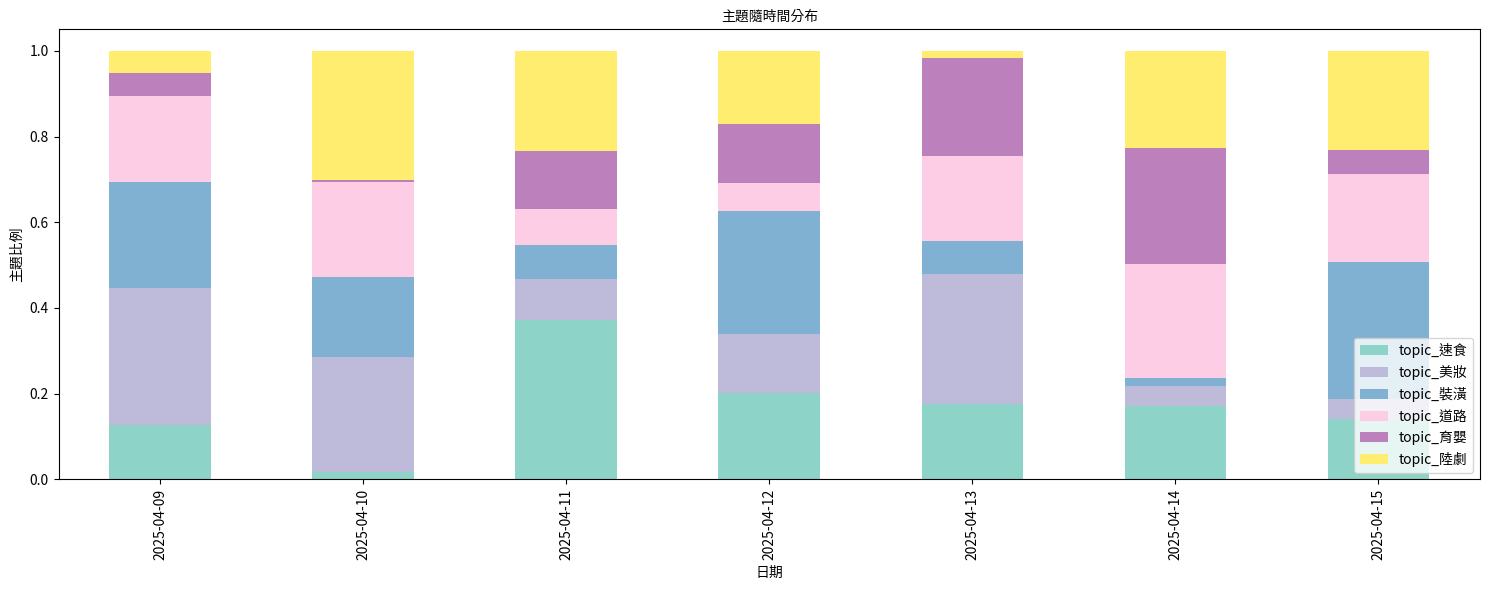

In [ ]:
np.random.seed(42) 

dates = pd.date_range(start='2025-04-09', end='2025-04-15')
topics = ['topic_速食', 'topic_美妝', 'topic_裝潢', 'topic_道路', 'topic_育嬰', 'topic_陸劇']
thetas = pd.DataFrame(np.random.rand(len(dates), len(topics)), index=dates, columns=topics)
thetas = thetas.div(thetas.sum(axis=1), axis=0)  # 正規化成每日主題比例
thetas.index = thetas.index.strftime('%Y-%m-%d')  # 轉成字串作為 x 軸

# 畫圖
fig, ax = plt.subplots(figsize=(15, 6))
thetas.plot.bar(ax=ax, stacked=True, colormap='Set3')

ax.set_xlabel('日期')
ax.set_ylabel('主題比例')
ax.set_title('主題隨時間分布', fontproperties=font_prop)
ax.legend(loc='lower right', prop=font_prop)

plt.tight_layout()
plt.show()

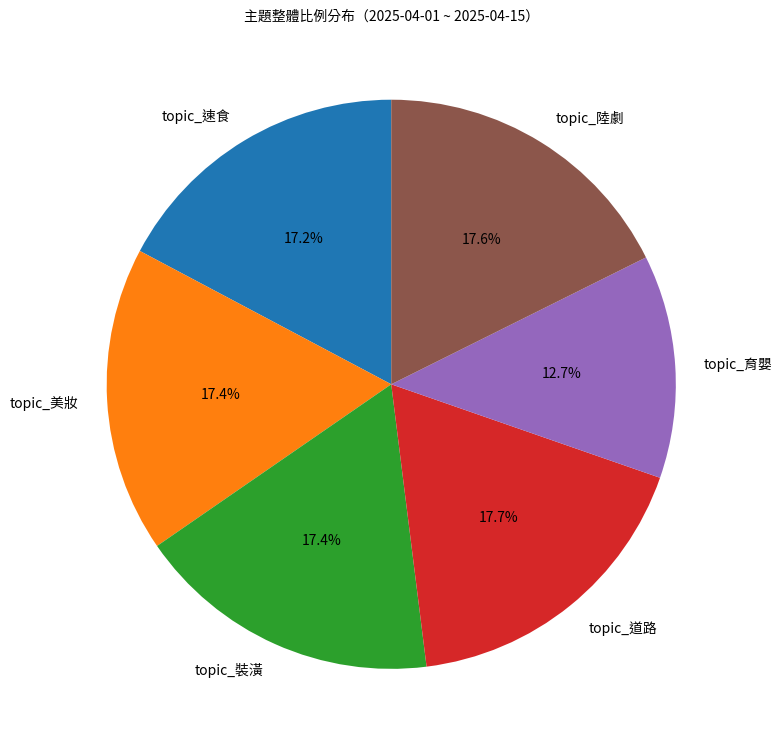

In [ ]:
# 繪製圓餅圖（整體比例）
topic_sums = thetas.sum(axis=0)
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    topic_sums,
    labels=topic_sums.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontproperties': font_prop}
)
ax.set_title('主題整體比例分布（2025-04-01 ~ 2025-04-15）', fontproperties=font_prop)
plt.tight_layout()
plt.show()

可以看出2025/4/9-2025/4/15(一個禮拜)育嬰相關的話題討論最少

## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

### **4.1 正式處理主題分析**

將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = udn['words'].to_list()
docs[10]

['餐點',
 '缺北市',
 '失控',
 '掀翻',
 '麥當勞',
 '內用',
 '顧客',
 '嚇瘋急',
 '記者',
 '蕭沁梅',
 '許稚佳',
 '報導',
 '發佈',
 '更新',
 '台北市',
 '大安區',
 '昨日',
 '發生',
 '糾紛案',
 '一名',
 '女子',
 '晚間',
 '時許',
 '前往',
 '忠孝東路',
 '麥當勞',
 '費時',
 '店家',
 '餐點',
 '短缺',
 '一時',
 '情緒',
 '失控',
 '竟將',
 '內用',
 '顧客',
 '餐點',
 '全掃落',
 '民眾',
 '見狀',
 '嚇得',
 '趕緊',
 '收拾',
 '包包',
 '逃離',
 '警方',
 '獲報',
 '到場',
 '時見',
 '情緒',
 '稍微',
 '平復',
 '現場',
 '顧客',
 '表示',
 '不予',
 '追究',
 '最終',
 '協助',
 '店家',
 '將陳女',
 '勸離',
 '店家',
 '重新',
 '製作',
 '打翻',
 '顧客',
 '餐點',
 '事情',
 '落幕',
 '目擊',
 '民眾',
 '拍下',
 '影片',
 '上傳',
 '社群',
 '平台',
 '畫面',
 '女子',
 '突然',
 '大吼',
 '衝向',
 '內用區',
 '口中',
 '不斷',
 '怒罵',
 '著五字經',
 '一一',
 '將桌',
 '客人',
 '餐點',
 '掀翻',
 '還拿',
 '餐點',
 '窗戶',
 '現場',
 '薯條',
 '飲料',
 '灑落',
 '一旁',
 '民眾',
 '全看',
 '傻眼',
 '紛紛',
 '收拾',
 '包包',
 '逃離',
 '深怕',
 '受到',
 '波及',
 '大安',
 '分局',
 '指出',
 '昨日',
 '晚間',
 '時許',
 '接獲',
 '通報',
 '一名',
 '女子',
 '前往',
 '忠孝東路',
 '麥當勞',
 '費時',
 '店家',
 '餐點',
 '短缺',
 '一時',
 '情緒',
 '失控',
 '竟將',
 '內用',
 '顧客',
 '餐點',
 '全掃落',
 '警方',
 '獲報',
 '到場',
 '時見',
 '女子',


建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-19 22:49:30,388 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2025-04-19 22:49:30,765 : INFO : built Dictionary<74080 unique tokens: ['優惠', '優惠券', '必勝客', '肯德基', '上市']...> from 4441 documents (total 547557 corpus positions)
2025-04-19 22:49:30,766 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<74080 unique tokens: ['優惠', '優惠券', '必勝客', '肯德基', '上市']...> from 4441 documents (total 547557 corpus positions)", 'datetime': '2025-04-19T22:49:30.766765', 'gensim': '4.3.3', 'python': '3.11.0 (main, Mar  1 2023, 18:26:19) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-135-generic-x86_64-with-glibc2.35', 'event': 'created'}
2025-04-19 22:49:30,814 : INFO : discarding 61219 tokens: [('且將', 2), ('台灣將', 2), ('多吃點', 2), ('搶到', 1), ('搶購', 2), ('撲空', 2), ('熱潮', 4), ('紛紛表示', 4), ('賣光', 1), ('超人氣', 3)]...
2025-04-19 22:49:30,815 : INFO : keeping 12861 tokens which were in no less than 5 and no more than 4396 (=99.0%) documents
2025-04-19 22:49:30,835 : INFO : resulting dictionary: Dictionary<12861 unique tokens: ['優惠', '優惠券', '必勝客', '肯德基', '上市']...>


Dictionary<12861 unique tokens: ['優惠', '優惠券', '必勝客', '肯德基', '上市']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

優惠: 0
優惠券: 1
必勝客: 2
肯德基: 3
上市: 4
人潮: 5
傳出: 6
公佈: 7
厲害: 8
去年: 9
台灣: 10
吃過: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(udn['words'].iloc[600]))


'緯來 戲劇 台要 上映 長相思 官方 用心 舉辦 貼機 活動 相關 活動 資訊 參考 緯來 戲劇 貼機 廠商 官網 活動 興趣 板友'


第600篇文章的前十個詞彙的語料庫ID和頻率

In [ ]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(35, 3),
 (39, 1),
 (48, 1),
 (194, 1),
 (727, 1),
 (740, 1),
 (1129, 1),
 (1505, 1),
 (2042, 1),
 (2749, 1)]

#### 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### **4.2 開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-04-19 22:49:42,337 : INFO : using symmetric alpha at 0.1
2025-04-19 22:49:42,340 : INFO : using symmetric eta at 0.1
2025-04-19 22:49:42,345 : INFO : using serial LDA version on this node
2025-04-19 22:49:42,361 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 4441 documents, updating model once every 2000 documents, evaluating perplexity every 4441 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 22:49:42,362 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-19 22:49:42,363 : INFO : PROGRESS: pass 0, at document #2000/4441
2025-04-19 22:49:43,250 : INFO : merging changes from 2000 documents into a model of 4441 documents
2025-04-19 22:49:43,257 : INFO : topic #8 (0.100): 0.007*"房屋" + 0.007*"裝潢" + 0.005*"報價" + 0.005*"蓮花" + 0.005*"說明" + 0.004*"漢堡" + 0.004*"聯絡" + 0.004*"案件" + 0.004*"地點" + 0.004*"需求"
2025-04-19 22:49

### **4.3 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [ ]:
ldamodel.print_topics()

2025-04-19 22:49:45,778 : INFO : topic #0 (0.100): 0.009*"皮膚" + 0.007*"顏色" + 0.007*"睫毛" + 0.007*"眉毛" + 0.006*"推薦" + 0.006*"車輛" + 0.005*"補貨" + 0.004*"寶寶" + 0.004*"超級" + 0.004*"狀況"
2025-04-19 22:49:45,780 : INFO : topic #1 (0.100): 0.017*"交通" + 0.017*"房屋" + 0.014*"裝潢" + 0.012*"工程" + 0.009*"寶寶" + 0.009*"需求" + 0.008*"公尺" + 0.008*"說明" + 0.007*"聯絡" + 0.007*"預算"
2025-04-19 22:49:45,782 : INFO : topic #2 (0.100): 0.008*"定妝" + 0.007*"礦物" + 0.005*"回購" + 0.005*"房屋" + 0.005*"無瑕" + 0.005*"事故" + 0.004*"高鐵" + 0.004*"偏橘" + 0.004*"請問" + 0.004*"預告"
2025-04-19 22:49:45,784 : INFO : topic #3 (0.100): 0.014*"質地" + 0.014*"顏色" + 0.008*"適合" + 0.008*"日本" + 0.007*"提亮" + 0.006*"效果" + 0.005*"霧面" + 0.004*"影片" + 0.004*"推薦" + 0.003*"這款"
2025-04-19 22:49:45,785 : INFO : topic #4 (0.100): 0.012*"眼影" + 0.007*"寶寶" + 0.006*"公里" + 0.005*"購入" + 0.005*"孩子" + 0.005*"推薦" + 0.005*"工程" + 0.005*"顏色" + 0.005*"老師" + 0.005*"適合"
2025-04-19 22:49:45,786 : INFO : topic #5 (0.100): 0.017*"膚色" + 0.010*"產品" + 0.007*"選手" + 0.007*"定妝" + 0.

[(0,
  '0.009*"皮膚" + 0.007*"顏色" + 0.007*"睫毛" + 0.007*"眉毛" + 0.006*"推薦" + 0.006*"車輛" + 0.005*"補貨" + 0.004*"寶寶" + 0.004*"超級" + 0.004*"狀況"'),
 (1,
  '0.017*"交通" + 0.017*"房屋" + 0.014*"裝潢" + 0.012*"工程" + 0.009*"寶寶" + 0.009*"需求" + 0.008*"公尺" + 0.008*"說明" + 0.007*"聯絡" + 0.007*"預算"'),
 (2,
  '0.008*"定妝" + 0.007*"礦物" + 0.005*"回購" + 0.005*"房屋" + 0.005*"無瑕" + 0.005*"事故" + 0.004*"高鐵" + 0.004*"偏橘" + 0.004*"請問" + 0.004*"預告"'),
 (3,
  '0.014*"質地" + 0.014*"顏色" + 0.008*"適合" + 0.008*"日本" + 0.007*"提亮" + 0.006*"效果" + 0.005*"霧面" + 0.004*"影片" + 0.004*"推薦" + 0.003*"這款"'),
 (4,
  '0.012*"眼影" + 0.007*"寶寶" + 0.006*"公里" + 0.005*"購入" + 0.005*"孩子" + 0.005*"推薦" + 0.005*"工程" + 0.005*"顏色" + 0.005*"老師" + 0.005*"適合"'),
 (5,
  '0.017*"膚色" + 0.010*"產品" + 0.007*"選手" + 0.007*"定妝" + 0.005*"特別" + 0.004*"粉色" + 0.004*"推薦" + 0.004*"毛孔" + 0.004*"手邊" + 0.004*"妝容"'),
 (6,
  '0.021*"珠光" + 0.009*"顏色" + 0.008*"推薦" + 0.007*"四色" + 0.007*"逛逛" + 0.006*"花絮" + 0.005*"預告" + 0.005*"媽媽" + 0.004*"有沒有" + 0.004*"適合"'),
 (7,
  '0.022*"色號" + 0.015

Topic | 推測主題名稱 | 主題說明
- 0 | 美妝入門與眉妝選購 | 分享眉妝與產品建議、詢問購買方式等新手取向內容
- 1 | 裝潢設計與報價討論 | 居家裝潢需求、工程預算與報價討論
- 2 | 定妝與底妝產品使用心得 | 關於定妝產品使用經驗、上妝持久性、礦物底妝與粉體類產品的效果回饋
- 3 | 提亮系日本彩妝產品 | 聚焦在日本品牌的提亮型底妝、霧面妝感與珠光質地產品
- 4 | 寶寶育兒與醫療詢問 | 涉及孩子照顧、醫生建議、育兒過程中遇到的身心狀況與實務問題
- 5 | 肌膚修飾與膚色遮瑕技巧 | 針對膚色不均、妝容斑駁、選手級產品等修飾與遮瑕經驗的交流
- 6 | 彩妝產品評比與資訊交流 | 包含定妝產品、彩妝評比、四色眼影開箱與網友之間的產品交流與互動
- 7 | 護膚保養與膚況改善 | 毛孔、光澤、保養產品使用感想與肌膚質感改善經驗
- 8 | 粉質色調與質地體驗 | 專注於粉色系與粉嫩妝感、粉體質地與整體上臉效果
- 9 | 色號挑選與入手感想 | 分享不同色號的選擇心得、購買經驗與使用後的整體評價

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(0, 0.020012476),
 (1, 0.020008132),
 (2, 0.8199089),
 (3, 0.020008879),
 (4, 0.020010505),
 (5, 0.020010803),
 (6, 0.02001309),
 (7, 0.020008646),
 (8, 0.020009091),
 (9, 0.020009434)]

這邊可以看到corpus[0]這篇文章是由多個主題混合組成，每個主題都有其機率（權重）
其中主題2的佔比最高(0.77)

### **4.4 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-19 22:50:13,153 : INFO : -9.567 per-word bound, 758.7 perplexity estimate based on a held-out corpus of 4441 documents with 437891 words


-9.567451686614074

將 對數 perplexity 值轉回原始的 perplexity 值

In [ ]:
np.exp2(-perplexity)

758.7346880835314

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-04-19 22:50:15,222 : INFO : using ParallelWordOccurrenceAccumulator<processes=87, batch_size=64> to estimate probabilities from sliding windows
2025-04-19 22:50:17,236 : INFO : 1 batches submitted to accumulate stats from 64 documents (5236 virtual)
2025-04-19 22:50:17,243 : INFO : 2 batches submitted to accumulate stats from 128 documents (9241 virtual)
2025-04-19 22:50:17,246 : INFO : 3 batches submitted to accumulate stats from 192 documents (13964 virtual)
2025-04-19 22:50:17,249 : INFO : 4 batches submitted to accumulate stats from 256 documents (18178 virtual)
2025-04-19 22:50:17,251 : INFO : 5 batches submitted to accumulate stats from 320 documents (20704 virtual)
2025-04-19 22:50:17,253 : INFO : 6 batches submitted to accumulate stats from 384 documents (24089 virtual)
2025-04-19 22:50:17,256 : INFO : 7 batches submitted to accumulate stats from 448 documents (27867 virtual)
2025-04-19 22:50:17,258 : INFO : 8 batches submitted to accumulate stats from 512 documents (31311

這個主題模型的 PMI score:  -0.09694886379239348


也可以列出主題模型中，每個主題詞語之間的PMI score

In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.08788388931114838,
 0.04949891036191397,
 -0.4261322827107726,
 -0.05296433521948182,
 -0.17711058153015835,
 -0.09591352466202369,
 -0.13171047215250917,
 0.032533815366208446,
 0.03359541937527399,
 -0.11340169744123733]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

### **4.5 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~15 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 15)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2025-04-19 22:50:21,788 : INFO : using symmetric alpha at 0.5
2025-04-19 22:50:21,790 : INFO : using symmetric eta at 0.5
2025-04-19 22:50:21,794 : INFO : using serial LDA version on this node
2025-04-19 22:50:21,798 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 4441 documents, updating model once every 2000 documents, evaluating perplexity every 4441 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 22:50:21,799 : INFO : PROGRESS: pass 0, at document #2000/4441
2025-04-19 22:50:22,619 : INFO : merging changes from 2000 documents into a model of 4441 documents
2025-04-19 22:50:22,621 : INFO : topic #0 (0.500): 0.005*"花絮" + 0.005*"劇情" + 0.005*"優惠" + 0.004*"預告" + 0.004*"演員" + 0.004*"裝潢" + 0.003*"房屋" + 0.003*"播出" + 0.003*"小說" + 0.003*"設計"
2025-04-19 22:50:22,623 : INFO : topic #1 (0.500): 0.006*"麥當勞" + 0.006*"房屋" + 0.006*"花絮" + 0.005*"裝潢" + 0.004*"預告" + 0.004*"劇情" + 0.004*"平台" + 0.003*"角色" + 0.003*"優惠" + 0.003*

花費時間: 169.77813482284546 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5162.948607,0.046064
1,3,4292.773905,-0.007014
2,4,3661.458777,0.042428
3,5,3655.107286,0.001590
4,6,3625.212012,0.019222
5,7,3276.254215,0.067845
6,8,3227.405468,0.007284
7,9,3266.993119,-0.029337
8,10,3311.712504,-0.017336
9,11,3582.199761,-0.039625


<Axes: xlabel='topic_num'>

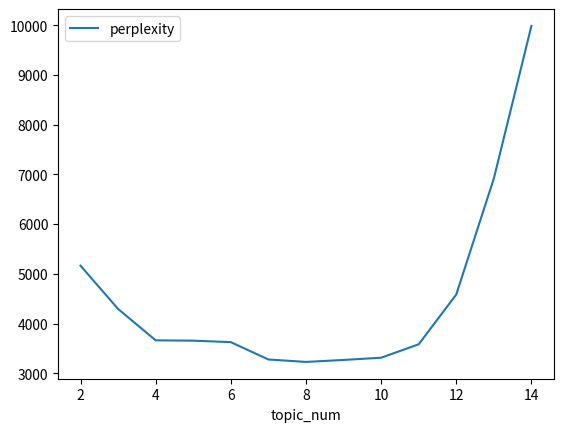

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

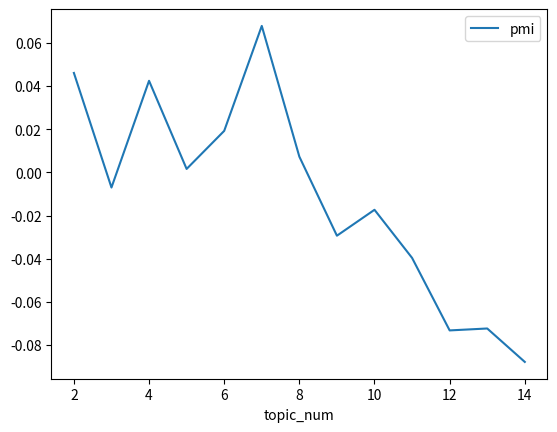

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 6 之後開始下降，coherence 最高則是 7

## 5. 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 10,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-19 22:59:09,529 : INFO : using symmetric alpha at 0.1
2025-04-19 22:59:09,531 : INFO : using symmetric eta at 0.1
2025-04-19 22:59:09,535 : INFO : using serial LDA version on this node
2025-04-19 22:59:09,552 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 4441 documents, updating model once every 2000 documents, evaluating perplexity every 4441 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 22:59:09,553 : INFO : PROGRESS: pass 0, at document #2000/4441
2025-04-19 22:59:10,478 : INFO : merging changes from 2000 documents into a model of 4441 documents
2025-04-19 22:59:10,485 : INFO : topic #7 (0.100): 0.008*"漢堡" + 0.005*"劇情" + 0.004*"角色" + 0.004*"套餐" + 0.004*"口味" + 0.003*"薯條" + 0.003*"這部" + 0.003*"演技" + 0.003*"麥當勞" + 0.003*"味道"
2025-04-19 22:59:10,486 : INFO : topic #0 (0.100): 0.008*"裝潢" + 0.008*"劇情" + 0.007*"設計" + 0.005*"房屋" + 0.004*"這部" + 0.004*"需求" + 0.003*"報價" + 0.003*"空間" + 0.003*"說明" + 0.003

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.157882  0.104684       1        1  24.475358
2      0.151803  0.029280       2        1  15.563727
1     -0.328579  0.113686       3        1  11.041577
7      0.076752 -0.240390       4        1  10.513339
3      0.203715  0.225750       5        1  10.253099
8      0.015484 -0.161507       6        1   6.547844
4      0.024503 -0.014752       7        1   6.332267
9      0.005609 -0.033370       8        1   5.835700
0     -0.103452 -0.127931       9        1   5.267115
5      0.112047  0.104551      10        1   4.169975, topic_info=       Term         Freq        Total Category  logprob  loglift
9301     房屋  1578.000000  1578.000000  Default  30.0000  30.0000
2365     裝潢  1498.000000  1498.000000  Default  29.0000  29.0000
10576    色號   976.000000   976.000000  Default  28.0000  28.0000
4082     寶寶  1095.000000  1095.000000  Default  27.0000  27.0000
4665     花絮   901.000000   901.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
5020   領銜主演    78.401208   189.480211  Topic10  -5.4506   2.2948
3831     塞車    57.902348   133.323680  Topic10  -5.7537   2.3432
1629     不知    56.056609   129.366757  Topic10  -5.7861   2.3410
10649    輕薄    54.004078   125.811095  Topic10  -5.8234   2.3315
8431     變更    48.323699   104.843391  Topic10  -5.9345   2.4027

[620 rows x 6 columns], token_table=      Topic      Freq Term
term                      
7938      9  0.184914   一上
7938     10  0.801293   一上
9279      4  0.017109   一歲
9279      6  0.958102   一歲
7670     10  0.974500   一輪
...     ...       ...  ...
56        6  0.002139  麥當勞
56        7  0.474824  麥當勞
56        8  0.515462  麥當勞
56       10  0.002139  麥當勞
943       8  0.971541   點餐

[1708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 8, 4, 9, 5, 10, 1, 6])

（7,8）都有速食相關的產品，但主題7偏向新生兒育嬰相關的議題

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-19 23:01:58,429 : INFO : using symmetric alpha at 0.16666666666666666
2025-04-19 23:01:58,431 : INFO : using symmetric eta at 0.16666666666666666
2025-04-19 23:01:58,435 : INFO : using serial LDA version on this node
2025-04-19 23:01:58,446 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 4441 documents, updating model once every 2000 documents, evaluating perplexity every 4441 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 23:01:58,447 : INFO : PROGRESS: pass 0, at document #2000/4441
2025-04-19 23:01:59,248 : INFO : merging changes from 2000 documents into a model of 4441 documents
2025-04-19 23:01:59,252 : INFO : topic #0 (0.167): 0.007*"裝潢" + 0.006*"劇情" + 0.005*"設計" + 0.004*"房屋" + 0.004*"這部" + 0.003*"需求" + 0.003*"角色" + 0.003*"空間" + 0.003*"說明" + 0.003*"地點"
2025-04-19 23:01:59,253 : INFO : topic #1 (0.167): 0.013*"房屋" + 0.012*"裝潢" + 0.007*"報價" + 0.006*"需求" + 0.005*"類型" + 0.005*"格局" + 0.005*"案件" + 0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.320016 -0.143462       1        1  34.471286
4     -0.107333 -0.014650       2        1  21.555310
2      0.022537  0.133720       3        1  15.299129
3     -0.005103  0.264885       4        1  14.410752
0      0.183174 -0.123599       5        1   9.893867
5      0.226741 -0.116894       6        1   4.369656, topic_info=      Term         Freq        Total Category  logprob  loglift
10004   工程  1596.000000  1596.000000  Default  30.0000  30.0000
4665    花絮   842.000000   842.000000  Default  29.0000  29.0000
9301    房屋  1522.000000  1522.000000  Default  28.0000  28.0000
4082    寶寶  1423.000000  1423.000000  Default  27.0000  27.0000
2365    裝潢  1453.000000  1453.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
12570   腮紅    94.010662   680.180507   Topic6  -5.3158   1.1515
1733    超級    71.014111   230.905329   Topic6  -5.5964   1.9514
1099    入手    68.143156   228.078672   Topic6  -5.6376   1.9224
68      今年    70.055801   477.015184   Topic6  -5.6099   1.2122
2424    適合    69.668349   539.775066   Topic6  -5.6155   1.0831

[435 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2974      1  0.006860   一邊
2974      2  0.130331   一邊
2974      3  0.727107   一邊
2974      4  0.054876   一邊
2974      5  0.041157   一邊
...     ...       ...  ...
4264      5  0.969469   黏膩
8018      3  0.033393  黑眼圈
8018      4  0.011131  黑眼圈
8018      5  0.935011  黑眼圈
8018      6  0.022262  黑眼圈

[1114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1, 6])

- 主題1:道路施工
- 主題2:媽媽懷孕期間就醫的情況（醫院附近都有麥當勞）
- 主題3:有可能是麥當勞推出新活動，影響交通
- 主題4:討論劇情
- 主題5:美妝試用效果
- 主題6:美妝推薦

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.11.0` 可正常執行

In [ ]:
import guidedlda

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('優惠', '優惠券', '必勝客', '肯德基', '上市', '人潮', '傳出', '公佈', '厲害', '去年')

In [ ]:
word2id = dictionary.token2id

In [ ]:
# 定義食衣住行育樂
seed_topic_list = [
    ["麥當勞", "炸雞", "薯條", "漢堡", "套餐"],
    ["眼影", "粉底", "唇膏", "定妝", "妝容"],
    ["房屋", "裝潢", "廚房", "坪數", "浴室"],
    ["交通", "車道", "工程", "施工", "人行道"],
    ["寶寶", "媽媽", "孩子", "照顧", "家庭"],
    ["劇情", "演員", "角色", "小說", "花絮"],
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-19 23:05:30,146 : INFO : n_documents: 4441
2025-04-19 23:05:30,147 : INFO : vocab_size: 12861
2025-04-19 23:05:30,148 : INFO : n_words: 437891
2025-04-19 23:05:30,148 : INFO : n_topics: 6
2025-04-19 23:05:30,149 : INFO : n_iter: 100


2025-04-19 23:05:30,213 : WARNING : all zero row in document-term matrix found
2025-04-19 23:05:33,690 : INFO : <0> log likelihood: -4875562
2025-04-19 23:05:33,954 : INFO : <20> log likelihood: -3579373
2025-04-19 23:05:34,198 : INFO : <40> log likelihood: -3557744
2025-04-19 23:05:34,439 : INFO : <60> log likelihood: -3551090
2025-04-19 23:05:34,681 : INFO : <80> log likelihood: -3546711
2025-04-19 23:05:34,918 : INFO : <99> log likelihood: -3544900


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 6
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 優惠 麥當勞 漢堡 套餐 口味 肯德基
Topic 1: 顏色 腮紅 適合 蓮花 眼影 推薦
Topic 2: 房屋 裝潢 需求 報價 說明 內信
Topic 3: 工程 改善 交通 人行道 路口 表示
Topic 4: 寶寶 孩子 小孩 媽媽 醫生 建議
Topic 5: 花絮 劇情 預告 演員 平台 角色


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.064265  0.004312       1        1  24.960127
3     -0.195285 -0.108159       2        1  24.840679
5      0.225828 -0.276023       3        1  17.989884
1      0.153720  0.123682       4        1  12.844047
2     -0.323558 -0.006775       5        1  11.909680
0      0.075030  0.262964       6        1   7.455584, topic_info=     Term         Freq        Total Category  logprob  loglift
9301   房屋  1710.000000  1710.000000  Default  30.0000  30.0000
2365   裝潢  1640.000000  1640.000000  Default  29.0000  29.0000
4082   寶寶  1418.000000  1418.000000  Default  28.0000  28.0000
0      優惠   740.000000   740.000000  Default  27.0000  27.0000
56    麥當勞   682.000000   682.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
29     日本   192.330884   407.951346   Topic6  -5.1343   1.8443
72     價格   175.390700   343.050090   Topic6  -5.2265   1.9253
35     活動   170.408292   342.213432   Topic6  -5.2553   1.8990
10     台灣   163.432922   501.997475   Topic6  -5.2971   1.4740
42     系列   117.594776   306.206437   Topic6  -5.6263   1.6392

[339 rows x 6 columns], token_table=      Topic      Freq Term
term                      
9955      5  1.002055   丈量
2179      2  0.993094   中央
2179      4  0.007820   中央
4827      3  0.998419   主演
536       3  0.903102   主角
...     ...       ...  ...
3693      2  1.000807   駕駛
5548      3  1.001352   騰訊
55        6  1.002988   鬆餅
738       6  1.003107   麥克
56        6  1.000513  麥當勞

[577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 2, 3, 1])

只有主題4需要做調整，有混合美妝和陸劇

In [ ]:
seed_topic_list = [
    ["麥當勞", "炸雞", "薯條", "漢堡", "套餐"],
    ["眼影", "粉底", "唇膏", "定妝", "妝容"],
    ["房屋", "裝潢", "廚房", "坪數", "浴室"],
    ["交通", "車道", "工程", "施工", "人行道"],
    ["寶寶", "媽媽", "孩子", "照顧", "家庭"],
    ["劇情", "演員", "角色", "小說", "花絮", "蓮花", "笛飛聲"],
]
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-19 23:11:28,677 : INFO : n_documents: 4441
2025-04-19 23:11:28,677 : INFO : vocab_size: 12861
2025-04-19 23:11:28,678 : INFO : n_words: 437891
2025-04-19 23:11:28,679 : INFO : n_topics: 6
2025-04-19 23:11:28,681 : INFO : n_iter: 100


2025-04-19 23:11:28,749 : WARNING : all zero row in document-term matrix found
2025-04-19 23:11:32,198 : INFO : <0> log likelihood: -4874261
2025-04-19 23:11:32,462 : INFO : <20> log likelihood: -3579566
2025-04-19 23:11:32,708 : INFO : <40> log likelihood: -3557772
2025-04-19 23:11:32,950 : INFO : <60> log likelihood: -3550045
2025-04-19 23:11:33,189 : INFO : <80> log likelihood: -3545137
2025-04-19 23:11:33,425 : INFO : <99> log likelihood: -3542476


In [ ]:
n_top_words = 6
topic_word = model.topic_word_

vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 優惠 麥當勞 漢堡 套餐 口味 肯德基
Topic 1: 顏色 腮紅 適合 眼影 推薦 唇膏
Topic 2: 房屋 裝潢 需求 報價 說明 內信
Topic 3: 工程 改善 交通 人行道 路口 表示
Topic 4: 寶寶 孩子 小孩 媽媽 醫生 建議
Topic 5: 花絮 劇情 預告 演員 平台 角色


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.068490  0.028430       1        1  25.358091
3     -0.193802  0.112143       2        1  24.881551
5      0.212381  0.257358       3        1  19.356593
2     -0.331156 -0.015074       4        1  11.684167
1      0.156277 -0.091217       5        1  11.513836
0      0.087808 -0.291639       6        1   7.205762, topic_info=     Term         Freq        Total Category  logprob  loglift
9301   房屋  1710.000000  1710.000000  Default  30.0000  30.0000
2365   裝潢  1640.000000  1640.000000  Default  29.0000  29.0000
4082   寶寶  1418.000000  1418.000000  Default  28.0000  28.0000
0      優惠   740.000000   740.000000  Default  27.0000  27.0000
56    麥當勞   682.000000   682.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
29     日本   184.342668   407.912635   Topic6  -5.1426   1.8360
35     活動   148.472520   342.238462   Topic6  -5.3590   1.7952
10     台灣   157.440057   501.981984   Topic6  -5.3004   1.4708
726    經典   117.584337   158.537447   Topic6  -5.5923   2.3315
42     系列   120.573516   306.173990   Topic6  -5.5672   1.6984

[339 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3028      1  1.000815  一個月
9955      4  1.002095   丈量
2179      2  0.990491   中央
2179      5  0.010426   中央
4827      3  0.998315   主演
...     ...       ...  ...
3693      2  1.000805   駕駛
5548      3  1.001248   騰訊
55        6  1.003077   鬆餅
738       6  0.996131   麥克
56        6  1.000602  麥當勞

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 3, 2, 1])

調整後有很好的被分類為食衣住育樂
- 主題1 : 有關家庭育嬰相關(育)
- 主題2 : 道路施工(行)
- 主題3 : 陸劇蓮花樓（樂）
- 主題4 : 房屋裝潢花費 (住)
- 主題5 : 美妝保養產品推薦 (衣)
- 主題6 : 速食產品分享 (食)

## 7. 主題分佈的應用，搭配其他文章資訊

訓練完LDA模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(4, 0.57371944), (5, 0.38668686)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.03333787, 0.03333788, 0.03333909, 0.03334486, 0.83297163,
        0.03366867],
       [0.        , 0.        , 0.        , 0.        , 0.96296012,
        0.03052469],
       [0.18874133, 0.02089724, 0.02094531, 0.02092914, 0.72741216,
        0.02107487],
       ...,
       [0.94048417, 0.        , 0.        , 0.        , 0.        ,
        0.04996393],
       [0.64040697, 0.        , 0.        , 0.        , 0.        ,
        0.35382164],
       [0.48634908, 0.        , 0.        , 0.        , 0.        ,
        0.50595218]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [ ]:
udn['topic_label'].value_counts()

topic_label
2    1391
5    1265
4     640
3     515
1     491
6     139
Name: count, dtype: int64

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,肯德基必勝客優惠券整理分享優惠可以使用以下連結,https://www.ptt.cc/bbs/fastfood/M.1744612474.A...,速食,2025-04-14 14:34:32,"[肯德基, 必勝客, 優惠券, 優惠]",5
1,麥當勞鬆餅堡台灣將再開賣業者證實這天上市記者陳昫蓁報導麥當勞厚鬆餅堡系列一上市立刻引起搶購熱...,https://www.ptt.cc/bbs/fastfood/M.1744616740.A...,速食,2025-04-14 15:45:35,"[麥當勞, 鬆餅, 台灣將, 開賣, 業者, 證實, 這天, 上市, 記者, 報導, 麥當勞...",5
2,只限今天要去領卷卡拉雞一送一可是還沒吃過莎莎卡拉快到期了看價錢又有點猶豫,https://www.ptt.cc/bbs/fastfood/M.1743562489.A...,速食,2025-04-02 10:54:47,"[領卷, 卡拉, 雞一送, 沒吃過, 莎莎, 卡拉, 到期, 價錢, 猶豫]",5
3,吉野家降價了逾款餐點最高現省元新菜單出爐日本連鎖丼飯店包含松屋家今年月陸續喊漲漲幅最高元不過...,https://www.ptt.cc/bbs/fastfood/M.1743568712.A...,速食,2025-04-02 12:38:30,"[吉野家, 降價, 逾款, 餐點, 最高, 現省, 菜單, 出爐, 日本, 連鎖, 飯店, ...",5
4,屯的漢堡王電子票券一個禮拜多前還能用剛剛去換每張櫃檯刷都顯示過期漢堡王是擺明要不認帳是不是那...,https://www.ptt.cc/bbs/fastfood/M.1743573159.A...,速食,2025-04-02 13:52:36,"[漢堡, 電子, 票券, 禮拜, 多前, 還能, 去換, 每張, 櫃檯, 顯示, 過期, 漢...",5


#### 查看每天每個主題的文章相對比例（占比）

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-07-01  5              0.500000
            2              0.250000
            6              0.250000
2024-07-02  5              0.444444
            1              0.333333
                             ...   
2025-04-14  5              0.416667
            2              0.250000
            4              0.166667
            1              0.083333
            3              0.083333
Name: proportion, Length: 1371, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6
artDate,,,,,,
2024-07-01,NaN,0.250000,NaN,NaN,0.500000,0.25
2024-07-02,0.333333,0.222222,NaN,NaN,0.444444,NaN
2024-07-03,0.166667,0.500000,NaN,NaN,0.333333,NaN
2024-07-04,NaN,1.000000,NaN,NaN,NaN,NaN
2024-07-05,0.375000,0.125000,NaN,NaN,0.500000,NaN


#### 視覺化呈現主題文章趨勢變化

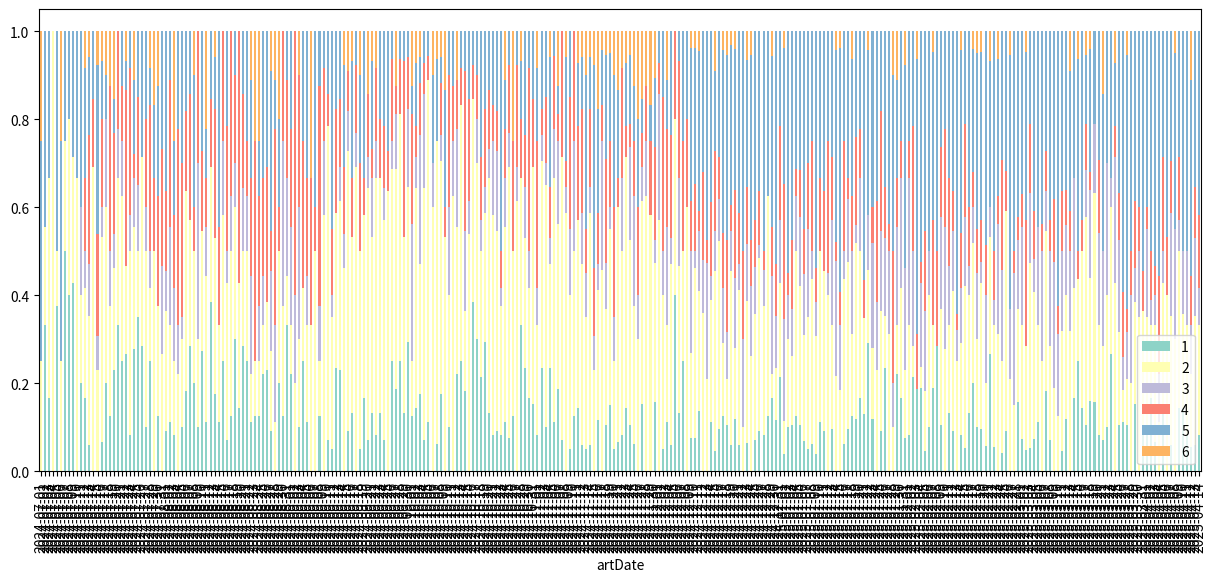

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

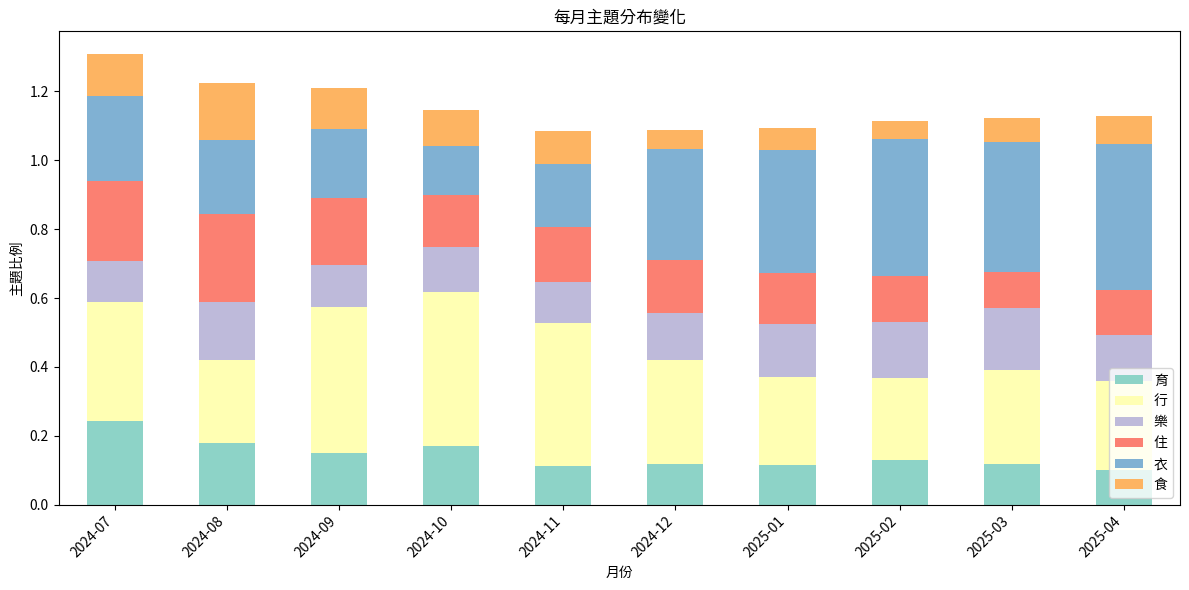

In [ ]:
date_topic.index = pd.to_datetime(date_topic.index)
monthly_topic = date_topic.groupby(date_topic.index.to_period("M")).mean()
monthly_topic.index = monthly_topic.index.astype(str)

# 自訂主題名稱（對應原本的 topic_0 ~ topic_5）
topic_names = [
    "育",   # topic_0
    "行",   # topic_1
    "樂",   # topic_2
    "住",   # topic_3
    "衣",   # topic_4
    "食"    # topic_5
]

monthly_topic.columns = topic_names

# 繪製堆疊長條圖
fig, ax = plt.subplots(figsize=(12, 6))
monthly_topic.plot.bar(ax=ax, stacked=True, color=plt.cm.Set3.colors)

# 加入標籤與標題
ax.set_xlabel('月份')
ax.set_ylabel('主題比例')
ax.set_title('每月主題分布變化')
ax.legend(loc='lower right')

# 顯示清楚的月份格式
ax.set_xticklabels(monthly_topic.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


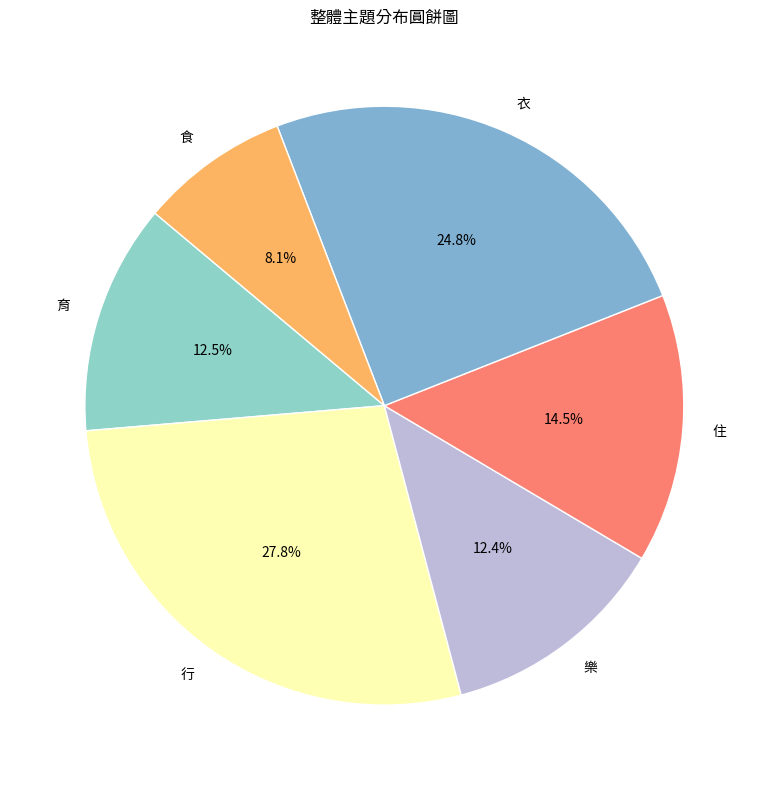

In [ ]:
# 加總每個主題在所有月份的比例
overall_topic_distribution = monthly_topic.sum()

# 畫圓餅圖
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    overall_topic_distribution,
    labels=overall_topic_distribution.index,
    autopct='%1.1f%%',
    colors=plt.cm.Set3.colors,
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)

ax.set_title("整體主題分布圓餅圖")
plt.tight_layout()
plt.show()

2024/7-2025/4/15 整體討論可以看出在行(道路施工)和衣(美妝)討論是最多的